# Time Series Anomaly Detction

## 1. Import Packages

First, We load the required packages

In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

from io import StringIO
import requests
 
from sklearn.preprocessing import MinMaxScaler
from keras_anomaly_detection.library.plot_utils import visualize_reconstruction_error
from keras_anomaly_detection.library.convolutional import Conv1DAutoEncoder

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from random import random

import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import json
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


Using TensorFlow backend.


## 2. Reading the time series data

In order to read the data it can be done by two different methods

### Option 1: Read the data directly from BigQuery. 

In order to read the data from BigQuery one needs the JSON file containing the authentication key in order to be able to excecute  queries involving said data. In this case Im gonna use the file "bigquery-test-228612-bbb8922fe944.json" located at my documents.

1. We need to define the query. The SELECT parameter goes the data wanted from de table, In this case we want all data contained in the BigQuery table  so  we use * . The FROM parameter specifies the BigQuery table that holds the data. 

In [2]:
query = """
SELECT *
FROM `bigquery-test-228612.ECGData.Test`
LIMIT 1000
"""

2. We excecute the query and save it into a dataframe, specifying the path to the key file and the project ID that holds the data in the cloud

In [3]:
df = pd.read_gbq(query,
                     project_id='bigquery-test-228612',
                     private_key='C:/Users/DELL/Documents/bigquery-test-228612-9d37266d3392.json',
                     dialect='standard')

3. We perform some manipulation of the data.

In [4]:
df=df.iloc[1:len(df.index),:]
Col=np.linspace(1,len(df.columns),len(df.columns))
df.columns=Col
df.head()

1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0    10.0   \
1   2.10   2.13   2.19   2.28   2.44   2.62   2.80   3.04   3.36   3.69   
2   2.06   2.05   2.06   2.07   2.08   2.13   2.22   2.37   2.53   2.71   
3   2.05   2.05   2.03   2.02   2.03   2.04   2.08   2.14   2.28   2.44   
4   2.07   2.04   2.03   2.05   2.05   2.04   2.05   2.09   2.14   2.22   
5   2.06   2.07   2.07   2.08   2.08   2.12   2.18   2.28   2.43   2.66   

   ...    201.0  202.0  203.0  204.0  205.0  206.0  207.0  208.0  209.0  210.0  
1  ...     2.99   2.74   2.61   2.47   2.35   2.26   2.20   2.15   2.10   2.08  
2  ...     3.62   3.38   3.17   2.92   2.64   2.45   2.33   2.23   2.13   2.08  
3  ...     3.71   3.33   3.01   2.74   2.55   2.51   2.30   2.17   2.10   2.08  
4  ...     3.27   3.02   2.74   2.54   2.39   2.27   2.17   2.13   2.11   2.07  
5  ...     2.31   2.22   2.16   2.12   2.08   2.08   2.08   2.07   2.06   2.09  

[5 rows x 210 columns]

### Option 2: Read the data directly from  the github source

Then, we read the ECG data

In [5]:
url='https://raw.githubusercontent.com/chen0040/keras-anomaly-detection/master/demo/ecg_demo/data/ecg_discord_test.csv'
s=requests.get(url).text
df=pd.read_csv(StringIO(s),header=None)
df.head()

0     1     2     3     4     5     6     7     8     9    ...    200  \
0  2.10  2.13  2.19  2.28  2.44  2.62  2.80  3.04  3.36  3.69  ...   2.99   
1  2.06  2.05  2.06  2.07  2.08  2.13  2.22  2.37  2.53  2.71  ...   3.62   
2  2.05  2.05  2.03  2.02  2.03  2.04  2.08  2.14  2.28  2.44  ...   3.71   
3  2.07  2.04  2.03  2.05  2.05  2.04  2.05  2.09  2.14  2.22  ...   3.27   
4  2.06  2.07  2.07  2.08  2.08  2.12  2.18  2.28  2.43  2.66  ...   2.31   

    201   202   203   204   205   206   207   208   209  
0  2.74  2.61  2.47  2.35  2.26  2.20  2.15  2.10  2.08  
1  3.38  3.17  2.92  2.64  2.45  2.33  2.23  2.13  2.08  
2  3.33  3.01  2.74  2.55  2.51  2.30  2.17  2.10  2.08  
3  3.02  2.74  2.54  2.39  2.27  2.17  2.13  2.11  2.07  
4  2.22  2.16  2.12  2.08  2.08  2.08  2.07  2.06  2.09  

[5 rows x 210 columns]

## 3. EDA and Visualization of the data

Now we perform an EDA over the data

In [6]:
Tdf=df.T
Tdf.describe()

0           1           2           3           4           5   \
count  210.000000  210.000000  210.000000  210.000000  210.000000  210.000000   
mean     5.197714    5.142667    5.091667    5.112571    5.073333    5.052095   
std      1.134086    1.141165    1.124836    1.208544    1.240130    1.219582   
min      2.080000    2.050000    2.020000    2.030000    2.060000    2.080000   
25%      5.010000    4.952500    4.970000    4.990000    4.972500    5.000000   
50%      5.140000    5.090000    5.110000    5.195000    5.170000    5.170000   
75%      5.807500    5.775000    5.697500    5.810000    5.825000    5.785000   
max      7.080000    7.050000    6.820000    6.930000    6.890000    6.840000   

               6           7           8           9      ...              13  \
count  210.000000  210.000000  210.000000  210.000000     ...      210.000000   
mean     5.189333    5.101000    5.157286    5.114429     ...        5.115476   
std      1.143697    1.180555    1.190994    1.199702     ...        1.198160   
min      2.090000    2.080000    2.090000    1.990000     ...        2.000000   
25%      5.032500    4.980000    5.000000    4.930000     ...        4.930000   
50%      5.220000    5.130000    5.120000    5.090000     ...        5.090000   
75%      5.840000    5.712500    5.825000    5.790000     ...        5.922500   
max      7.010000    6.950000    7.100000    7.040000     ...        6.870000   

               14          15          16          17          18          19  \
count  210.000000  210.000000  210.000000  210.000000  210.000000  210.000000   
mean     5.139381    5.046619    5.118905    5.158810    5.146905    5.202619   
std      1.211069    1.163220    1.213130    1.176845    1.203633    1.220693   
min      2.040000    2.080000    2.040000    2.070000    2.020000    2.040000   
25%      4.940000    4.980000    4.970000    4.970000    4.962500    4.970000   
50%      5.090000    5.120000    5.170000    5.090000    5.115000    5.155000   
75%      5.932500    5.605000    5.735000    5.860000    5.910000    6.035000   
max      6.980000    6.940000    7.070000    7.090000    6.980000    6.970000   

               20          21          22  
count  210.000000  210.000000  210.000000  
mean     5.040143    5.324238    5.132143  
std      0.867790    1.233114    1.178374  
min      3.660000    2.240000    2.060000  
25%      4.502500    5.070000    5.020000  
50%      5.040000    5.240000    5.100000  
75%      5.207500    6.065000    5.760000  
max      7.640000    7.410000    7.030000  

[8 rows x 23 columns]

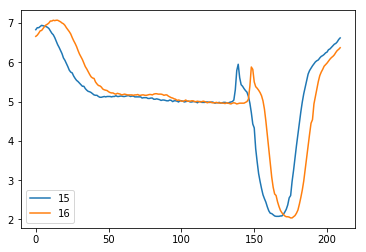

In [7]:
# The number and indexes of the series you want to plot
Tdf=df.iloc[15:17]
Tdf=Tdf.T
Tdf.plot()

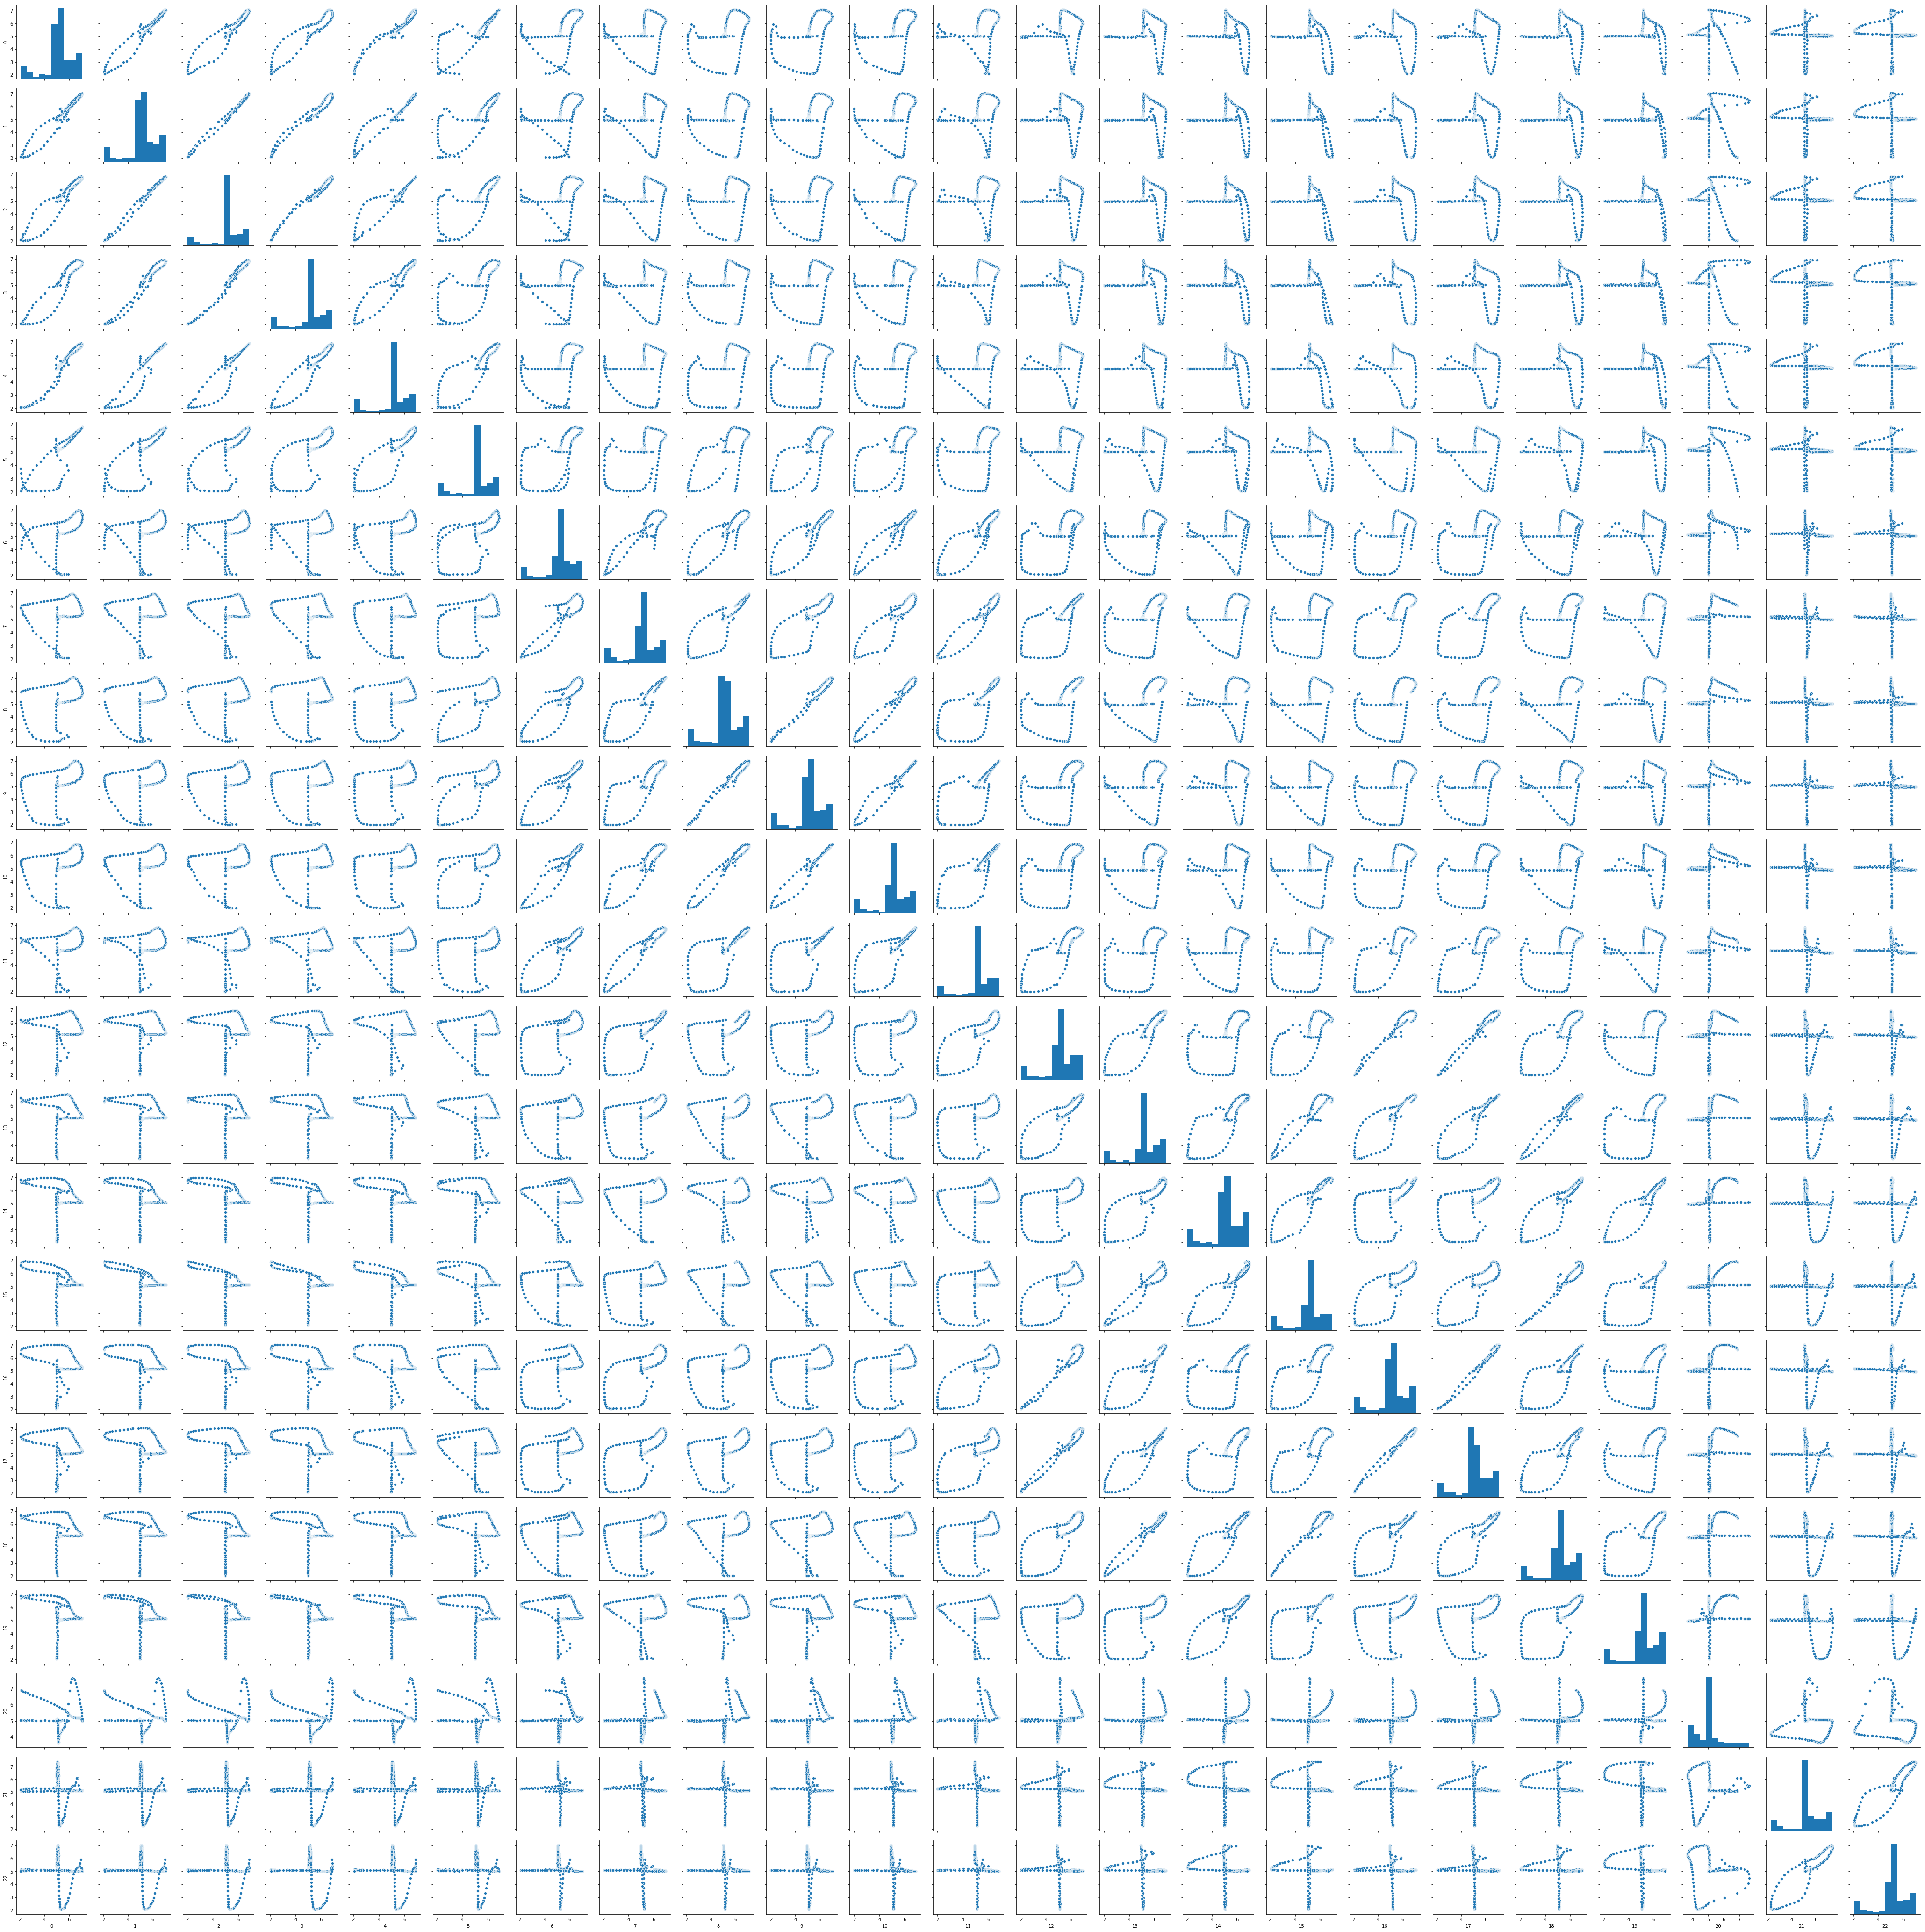

In [8]:
sns.pairplot(df.T)

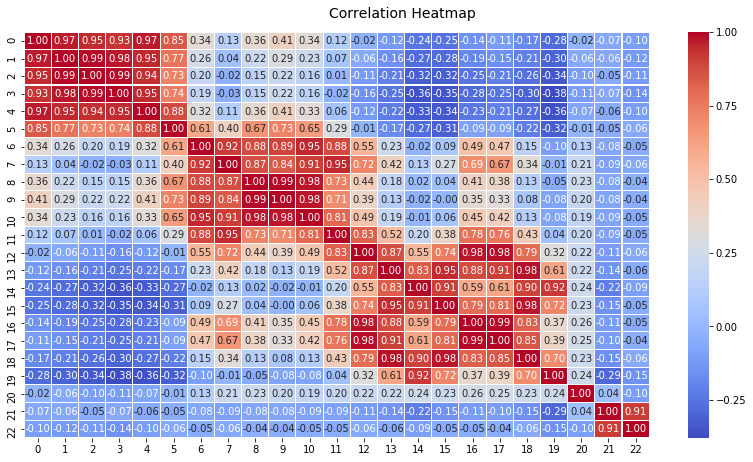

In [9]:
corr = (np.transpose(df)).corr()

f, ax = plt.subplots(figsize=(14, 7))
hm = sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=14)

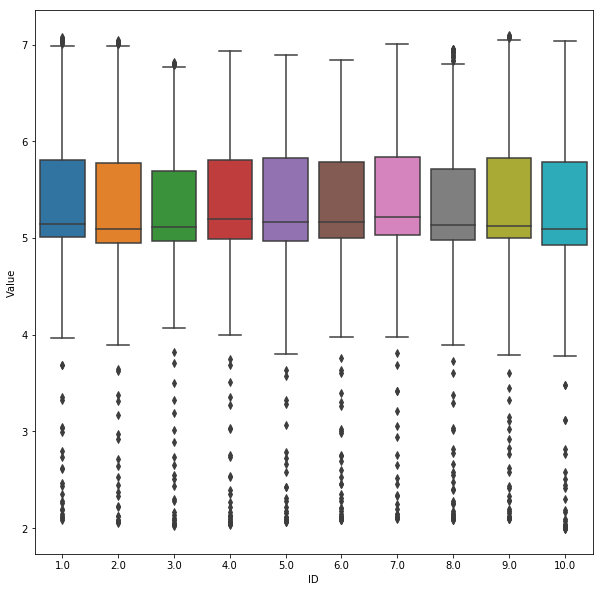

In [10]:
df['ID'] = pd.Series(np.linspace(1,len(df.index),len(df.index)), index=df.index)
Data = pd.melt(df.iloc[0:10,:],id_vars="ID",var_name="Series",value_name='Value') # Boxplot of the first 10 series
plt.figure(figsize=(10, 10))
sns.boxplot(x="ID", y="Value", data=Data)

## 4. Generation of New Data for Training and Validation

After the EDA we add some artificial outliers and inliers. Given the distribution of the data and its maximum and minimum values the new data was created as a continuous random number between 2 and 7

In [11]:
# Generate normal series
NormalSeriesNew=7   #How many new normal data you want 

for i in range (NormalSeriesNew):
    ls=[]
    for j in range(len(df.columns)):
        value = random()
        ls.append(2+(value*5))
    numEl = len(ls)
    newRow = pd.DataFrame(np.array(ls).reshape(1,numEl), columns = list(df.columns))
    df = df.append(newRow, ignore_index=True)
    
# Generate abnormal series  
AbnormalSeriesNew=5 #How many new normal data you want 
for i in range (AbnormalSeriesNew):
    ls=[]
    for j in range(len(df.columns)):
        value = random()
        ls.append((2+(value*5))*5)
    numEl = len(ls)
    newRow = pd.DataFrame(np.array(ls).reshape(1,numEl), columns = list(df.columns))
    df = df.append(newRow, ignore_index=True)
df

0          1          2          3          4          5  \
0    2.100000   2.130000   2.190000   2.280000   2.440000   2.620000   
1    2.060000   2.050000   2.060000   2.070000   2.080000   2.130000   
2    2.050000   2.050000   2.030000   2.020000   2.030000   2.040000   
3    2.070000   2.040000   2.030000   2.050000   2.050000   2.040000   
4    2.060000   2.070000   2.070000   2.080000   2.080000   2.120000   
5    2.100000   2.180000   2.280000   2.460000   2.690000   2.980000   
6    4.070000   4.380000   4.690000   4.930000   5.130000   5.340000   
7    6.000000   6.040000   6.080000   6.100000   6.140000   6.160000   
8    5.930000   5.970000   6.000000   6.060000   6.100000   6.150000   
9    5.360000   5.530000   5.650000   5.740000   5.800000   5.860000   
10   5.260000   5.570000   5.660000   5.740000   5.800000   5.840000   
11   5.700000   5.770000   5.840000   5.880000   5.910000   5.940000   
12   6.090000   6.110000   6.140000   6.170000   6.200000   6.210000   
13   6.270000   6.290000   6.340000   6.380000   6.420000   6.450000   
14   6.630000   6.680000   6.730000   6.760000   6.800000   6.850000   
15   6.830000   6.880000   6.880000   6.910000   6.940000   6.930000   
16   6.660000   6.690000   6.740000   6.800000   6.810000   6.860000   
17   6.420000   6.480000   6.510000   6.560000   6.610000   6.630000   
18   6.460000   6.490000   6.550000   6.610000   6.650000   6.680000   
19   6.710000   6.770000   6.820000   6.840000   6.870000   6.910000   
20   6.900000   6.890000   6.860000   6.820000   6.780000   6.730000   
21   5.040000   5.040000   5.040000   5.050000   5.050000   5.050000   
22   5.160000   5.150000   5.140000   5.140000   5.160000   5.170000   
23   5.804213   2.012050   4.089851   5.431032   6.294707   6.407326   
24   2.793436   4.237529   2.066581   3.524060   6.868945   4.496093   
25   6.119625   4.436260   6.691462   5.699218   6.914172   5.108834   
26   3.187350   6.840972   6.636128   6.070335   6.954283   3.140779   
27   3.967523   4.855274   3.530429   4.614740   4.714547   2.256423   
28   6.173307   3.222203   6.253150   2.699540   5.701320   3.824927   
29   5.232097   4.503427   4.320138   2.304386   3.766598   3.217730   
30  16.394026  11.374236  34.455634  17.893248  19.166615  27.709693   
31  16.086020  14.884804  13.000825  25.693291  27.040104  28.763945   
32  19.981689  13.176698  28.718324  34.936490  26.457105  24.869250   
33  23.958417  16.809918  19.652079  15.787753  13.275052  26.071565   
34  23.014737  32.061023  16.100497  29.114415  26.308745  24.702104   

            6          7          8          9    ...            201  \
0    2.800000   3.040000   3.360000   3.690000    ...       2.740000   
1    2.220000   2.370000   2.530000   2.710000    ...       3.380000   
2    2.080000   2.140000   2.280000   2.440000    ...       3.330000   
3    2.050000   2.090000   2.140000   2.220000    ...       3.020000   
4    2.180000   2.280000   2.430000   2.660000    ...       2.220000   
5    3.300000   3.640000   3.980000   4.280000    ...       2.110000   
6    5.550000   5.700000   5.780000   5.840000    ...       4.760000   
7    6.210000   6.240000   6.280000   6.330000    ...       4.690000   
8    6.180000   6.240000   6.280000   6.330000    ...       2.830000   
9    5.930000   5.970000   6.000000   6.050000    ...       2.770000   
10   5.870000   5.910000   5.960000   6.000000    ...       3.500000   
11   5.980000   6.020000   6.040000   6.050000    ...       5.640000   
12   6.280000   6.310000   6.370000   6.420000    ...       5.990000   
13   6.490000   6.550000   6.580000   6.600000    ...       6.240000   
14   6.880000   6.910000   6.930000   6.960000    ...       6.490000   
15   6.920000   6.910000   6.890000   6.860000    ...       6.320000   
16   6.910000   6.950000   6.970000   7.000000    ...       6.030000   
17   6.710000   6.750000   6.800000   6.850000    ...       6.060000   
18   6.720000   6.780000   6.820000   6.860000    .

With the complete data we create the labels for the outliers (1) and inliers (0)

In [12]:
labels=[]
Tdf= df.T
for i in range(len(df.index)):
    if Tdf[i].mean()<10:
        labels.append(0)
    else:
        labels.append(1)


## 5. Construcction of the NN for Anomaly Detection

Now with the data and labels we construct the NN model for the anomaly detection

In [13]:
from keras.callbacks import TensorBoard
from keras.layers import Conv1D, GlobalMaxPool1D, Dense, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from numpy.random import seed

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,write_graph=True, write_images=False)
df_np_data = df.values
scaler = MinMaxScaler()
df_np_data = scaler.fit_transform(df_np_data)

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', input_shape=(df_np_data.shape[1], 1)))
model.add(GlobalMaxPool1D())
model.add(Dense(units=df_np_data.shape[1], activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

Xin=np.expand_dims(df_np_data, axis=2)
Yin=df_np_data

seed(999)
model.fit(x=Xin, y=Yin,batch_size=8, epochs=100,verbose=2 ,validation_split=0.1, callbacks=[tensorboard])


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Train on 31 samples, validate on 4 samples
Epoch 1/100
 - 0s - loss: 0.0290 - mean_absolute_error: 0.1094 - val_loss: 0.4661 - val_mean_absolute_error: 0.6345
Epoch 2/100
 - 0s - loss: 0.0238 - mean_absolute_error: 0.0931 - val_loss: 0.3948 - val_mean_absolute_error: 0.5752
Epoch 3/100
 - 0s - loss: 0.0190 - mean_absolute_error: 0.0766 - val_loss: 0.3234 - val_mean_absolute_error: 0.5092
Epoch 4/100
 - 0s - loss: 0.0144 - mean_absolute_error: 0.0620 - val_loss: 0.2573 - val_mean_absolute_error: 0.4414
Epoch 5/100
 - 0s - loss: 0.0121 - mean_absolute_error: 0.0558 - val_loss: 0.2001 - val_mean_absolute_error: 0.3783
Epoch 6/100
 - 0s - loss: 0.0104 - mean_absolute_error: 0.0554 - val_loss: 0.1642 - val_mean_absolute_error: 0.3366
Epoch 7/100
 - 0s - loss: 0.0092 - mean_absolute_error: 0.0572 - val_loss: 0.1493 - val_mean_absolute_error: 0.3187
Epoch 8/100
 - 0s - loss: 0.0084 - mean_absolute_error: 0.0562 - val_loss: 0.1463 - val_mean_absolute_error: 0.3152
Epoch 9/100
 - 0s - loss: 0.0

Epoch 71/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0273 - val_loss: 0.1175 - val_mean_absolute_error: 0.2808
Epoch 72/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0272 - val_loss: 0.1174 - val_mean_absolute_error: 0.2808
Epoch 73/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0271 - val_loss: 0.1172 - val_mean_absolute_error: 0.2806
Epoch 74/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0269 - val_loss: 0.1175 - val_mean_absolute_error: 0.2811
Epoch 75/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0267 - val_loss: 0.1175 - val_mean_absolute_error: 0.2810
Epoch 76/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0266 - val_loss: 0.1179 - val_mean_absolute_error: 0.2815
Epoch 77/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0265 - val_loss: 0.1180 - val_mean_absolute_error: 0.2816
Epoch 78/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0264 - val_loss: 0.1178 - val_mean_absolute_error: 0.2814
Epoch 79/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0262 

In order to view the results in tensorboard, open the console and type: tensorboard --logdir C:\Users\DELL\Documents\logs --host=127.0.0.1 and press enter

After pressing enter the console will show a direction. Open your browser and paste the direction. This direction will send you to the tensorboard panel

The argument "C:\Users\DELL\Documents\logs" refers to your log directory

It should show you something like this

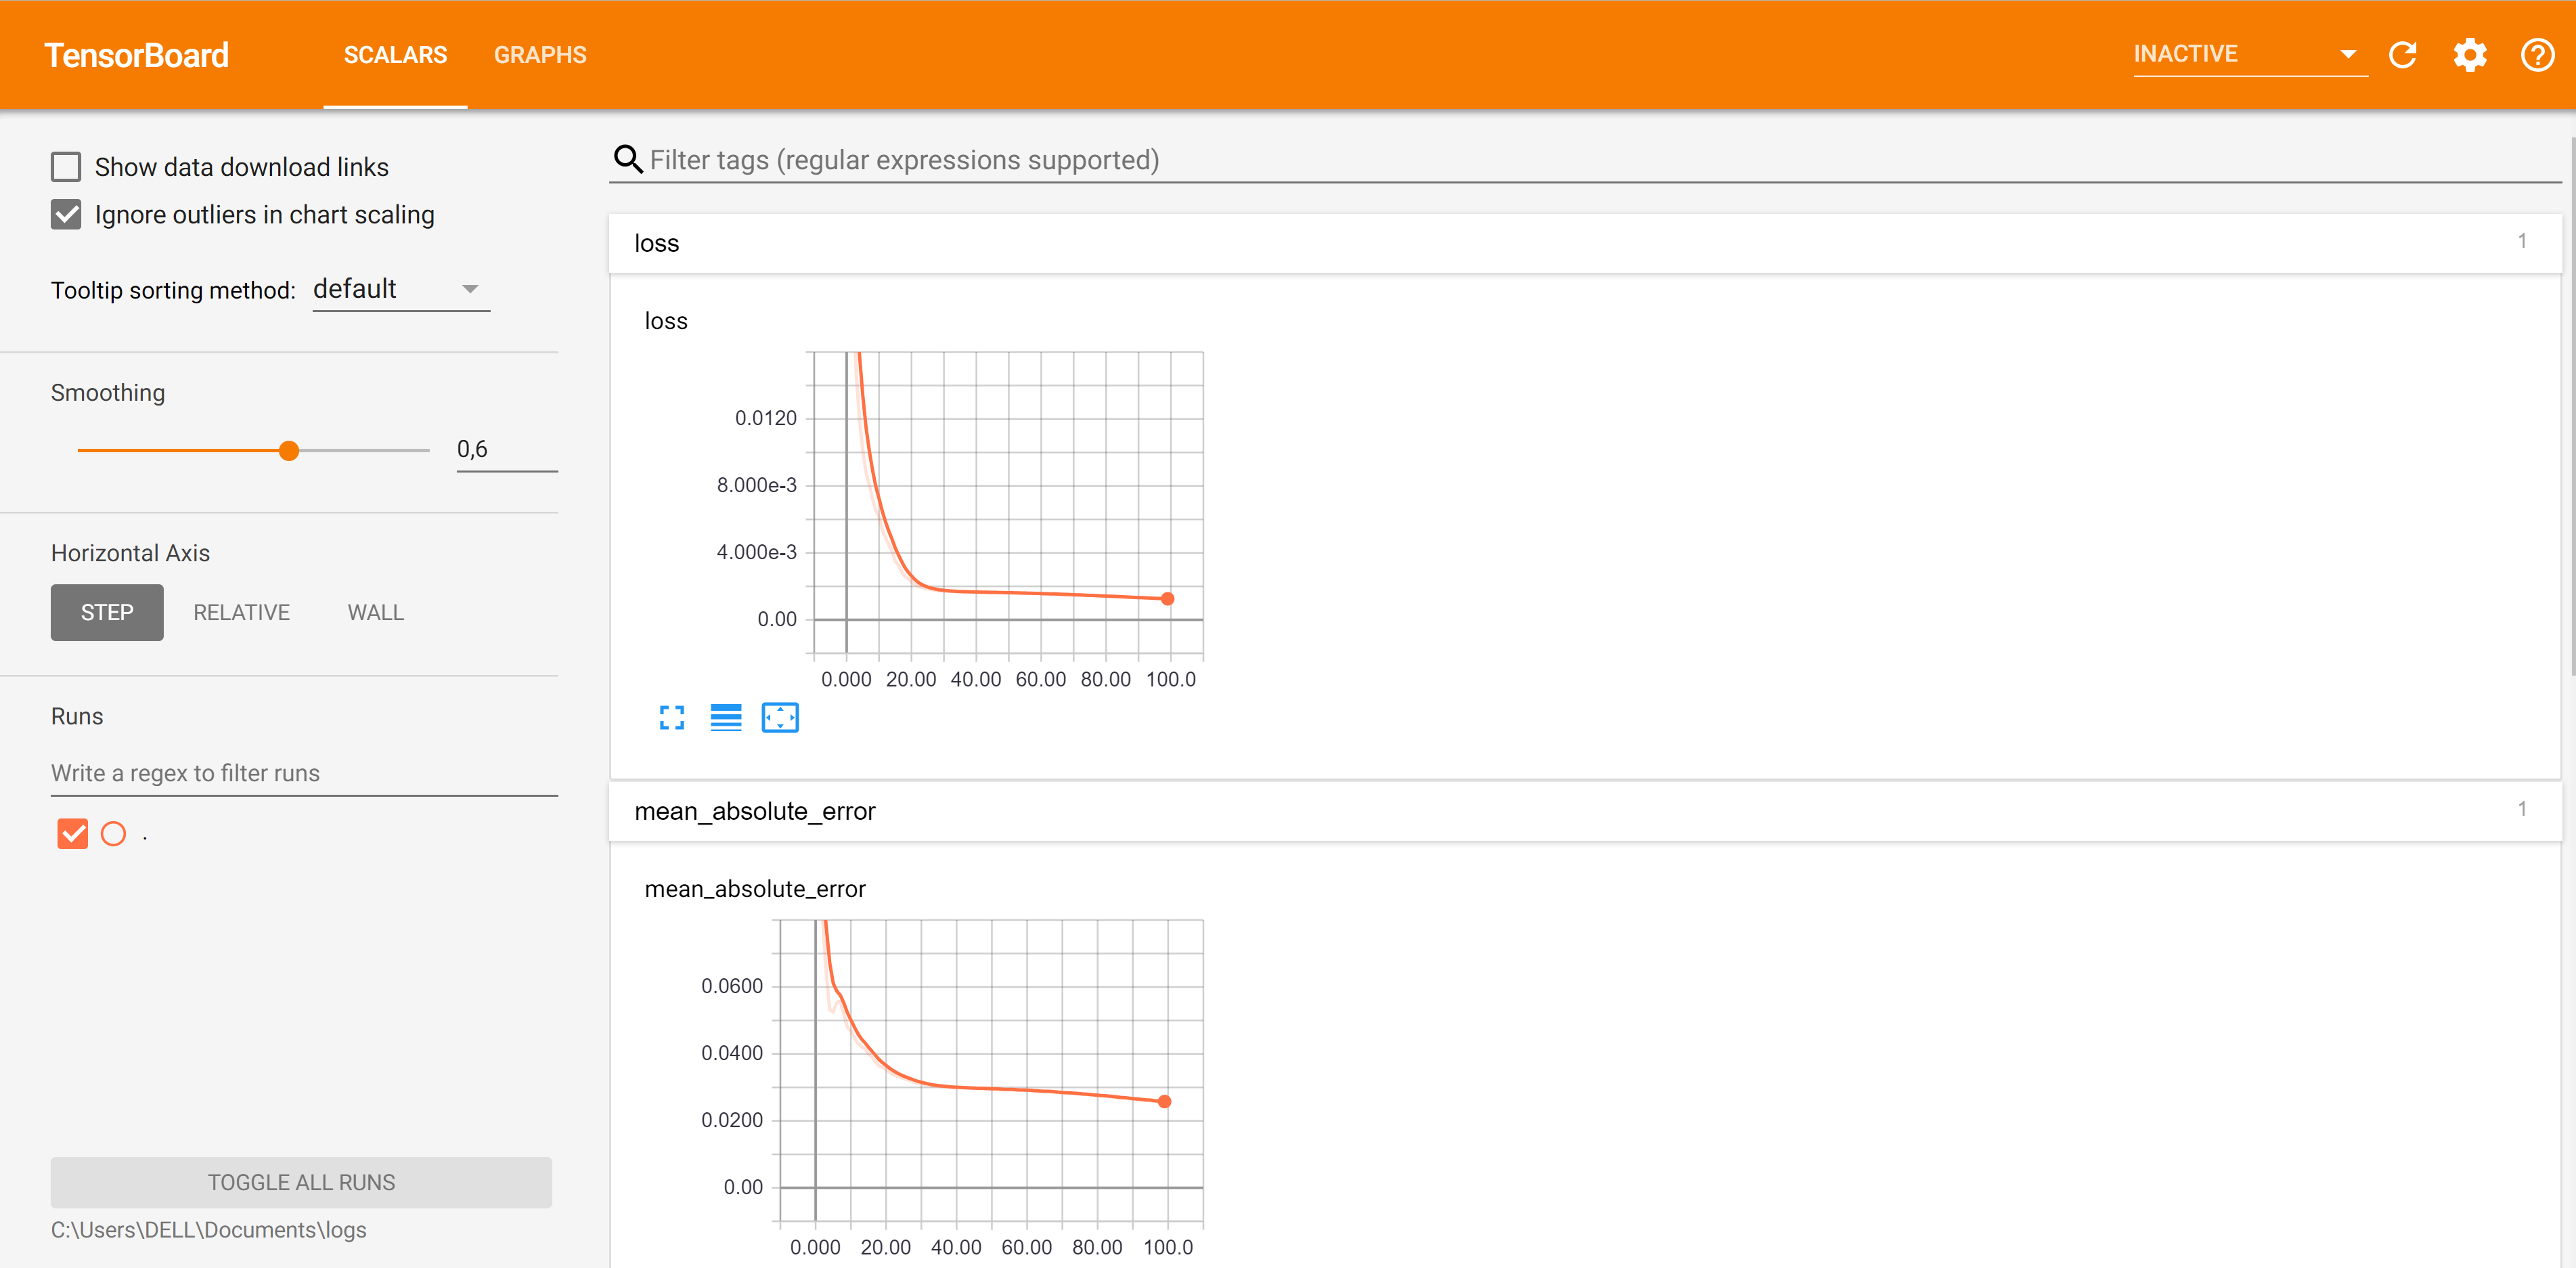

In [14]:
from IPython.display import Image

i = Image(filename='C:/Users/DELL/Pictures/TensorBoard/Conv1D/1.PNG')
i


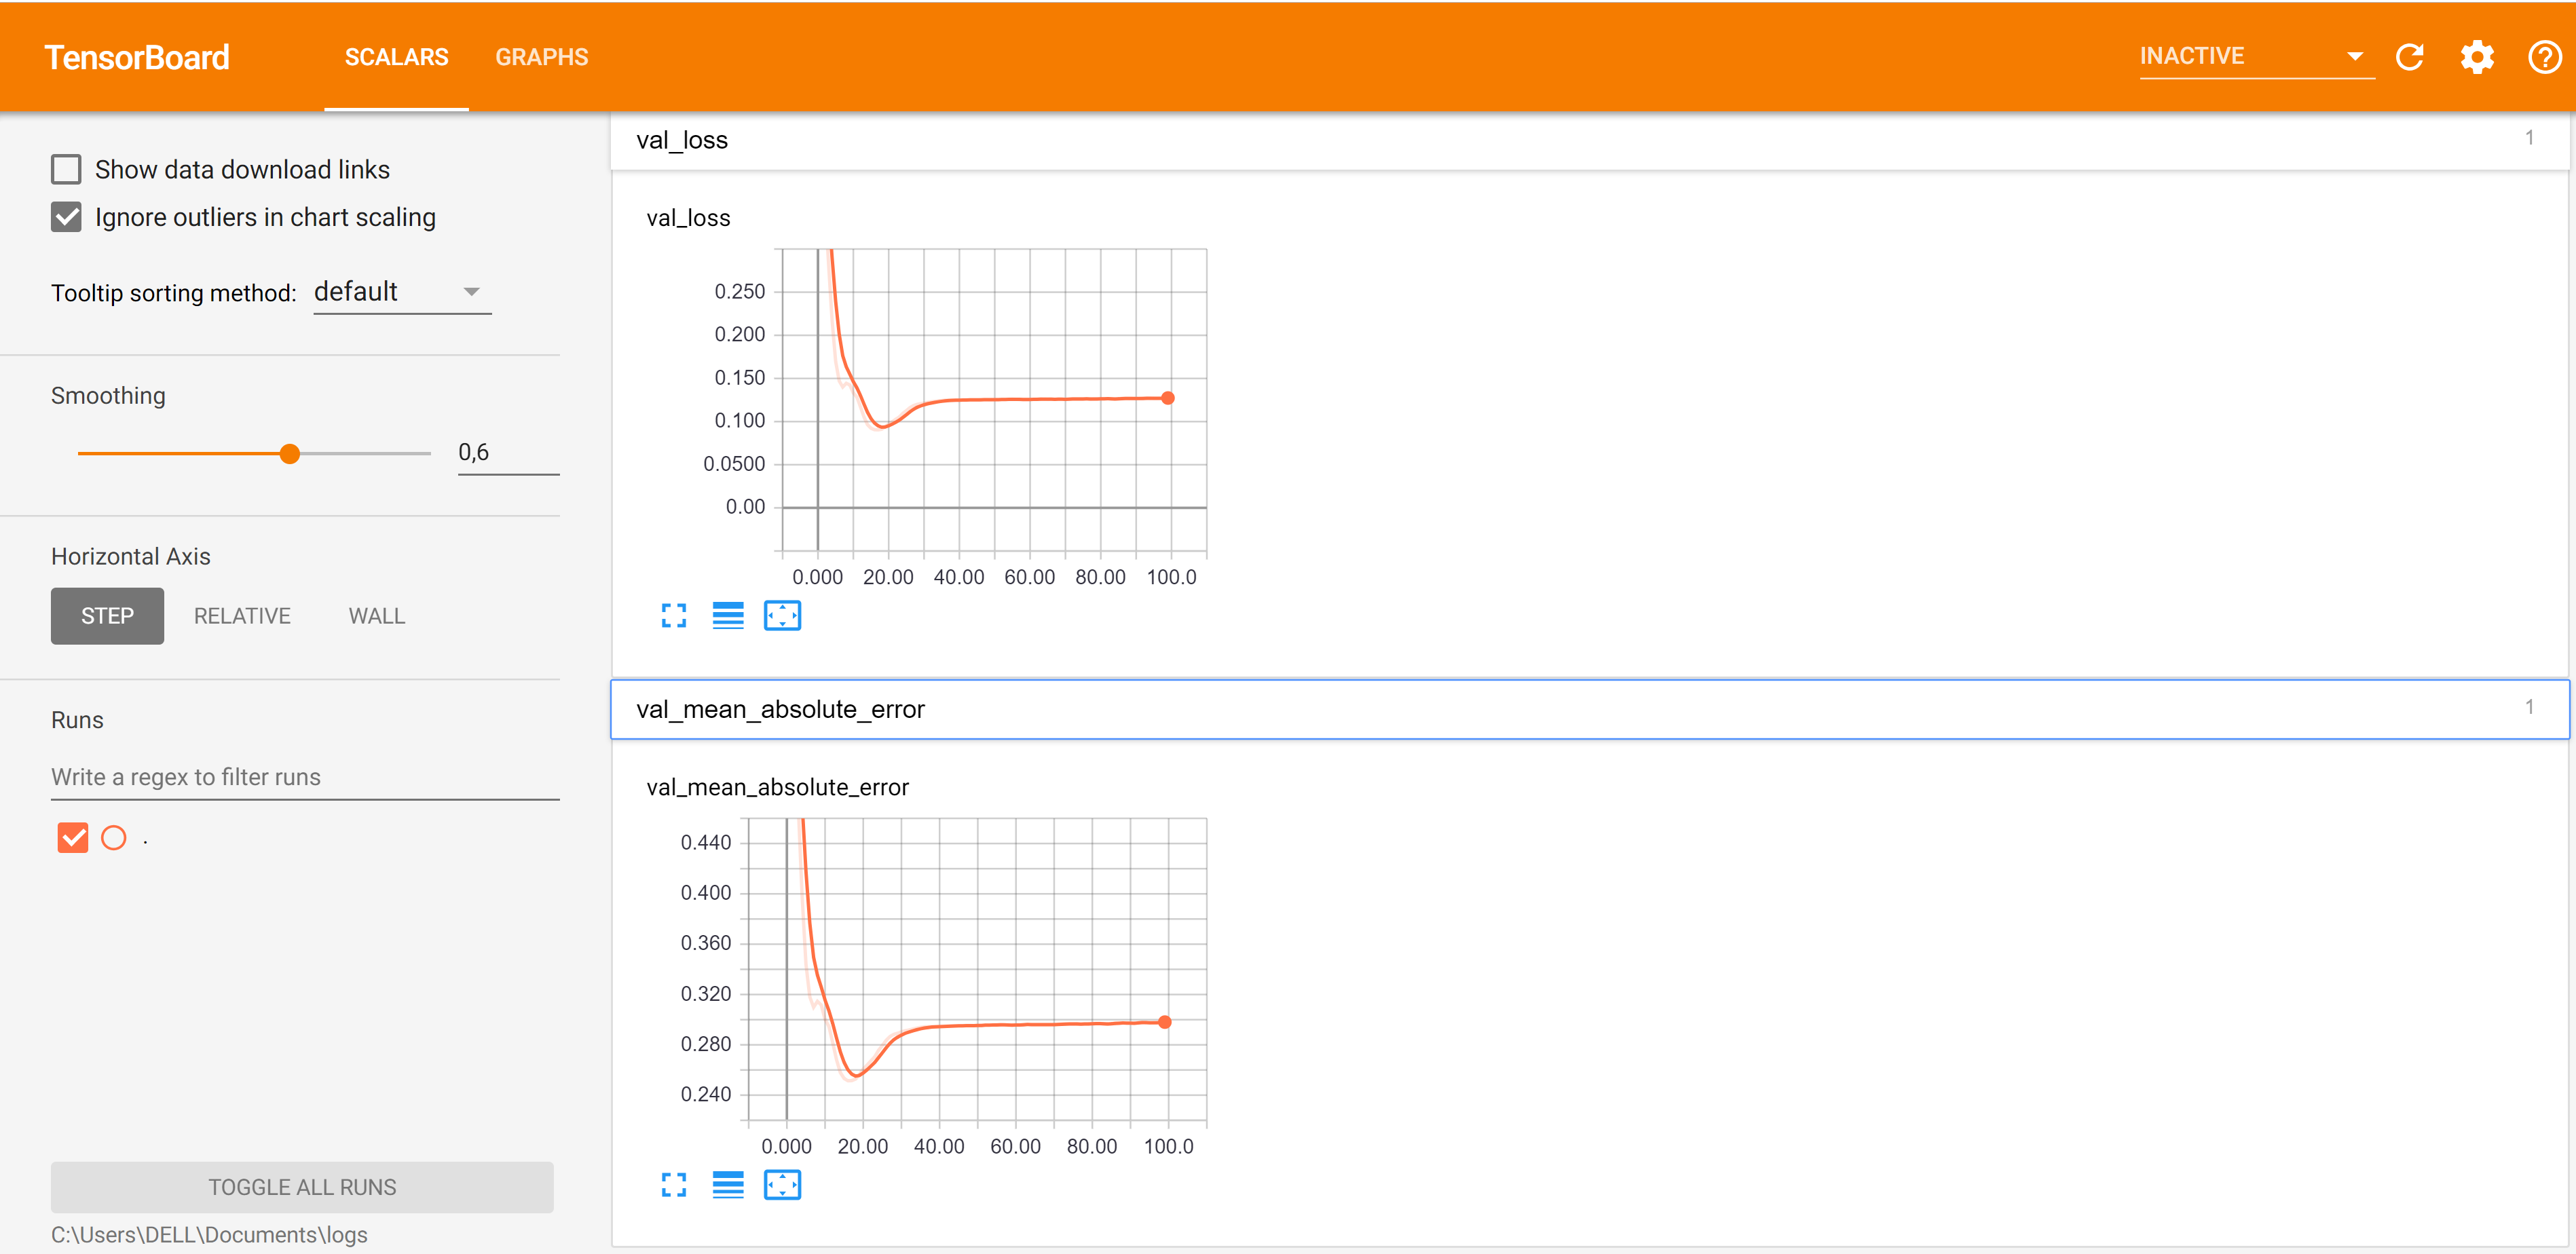

In [15]:
i = Image(filename='C:/Users/DELL/Pictures/TensorBoard/Conv1D/2.PNG')
i

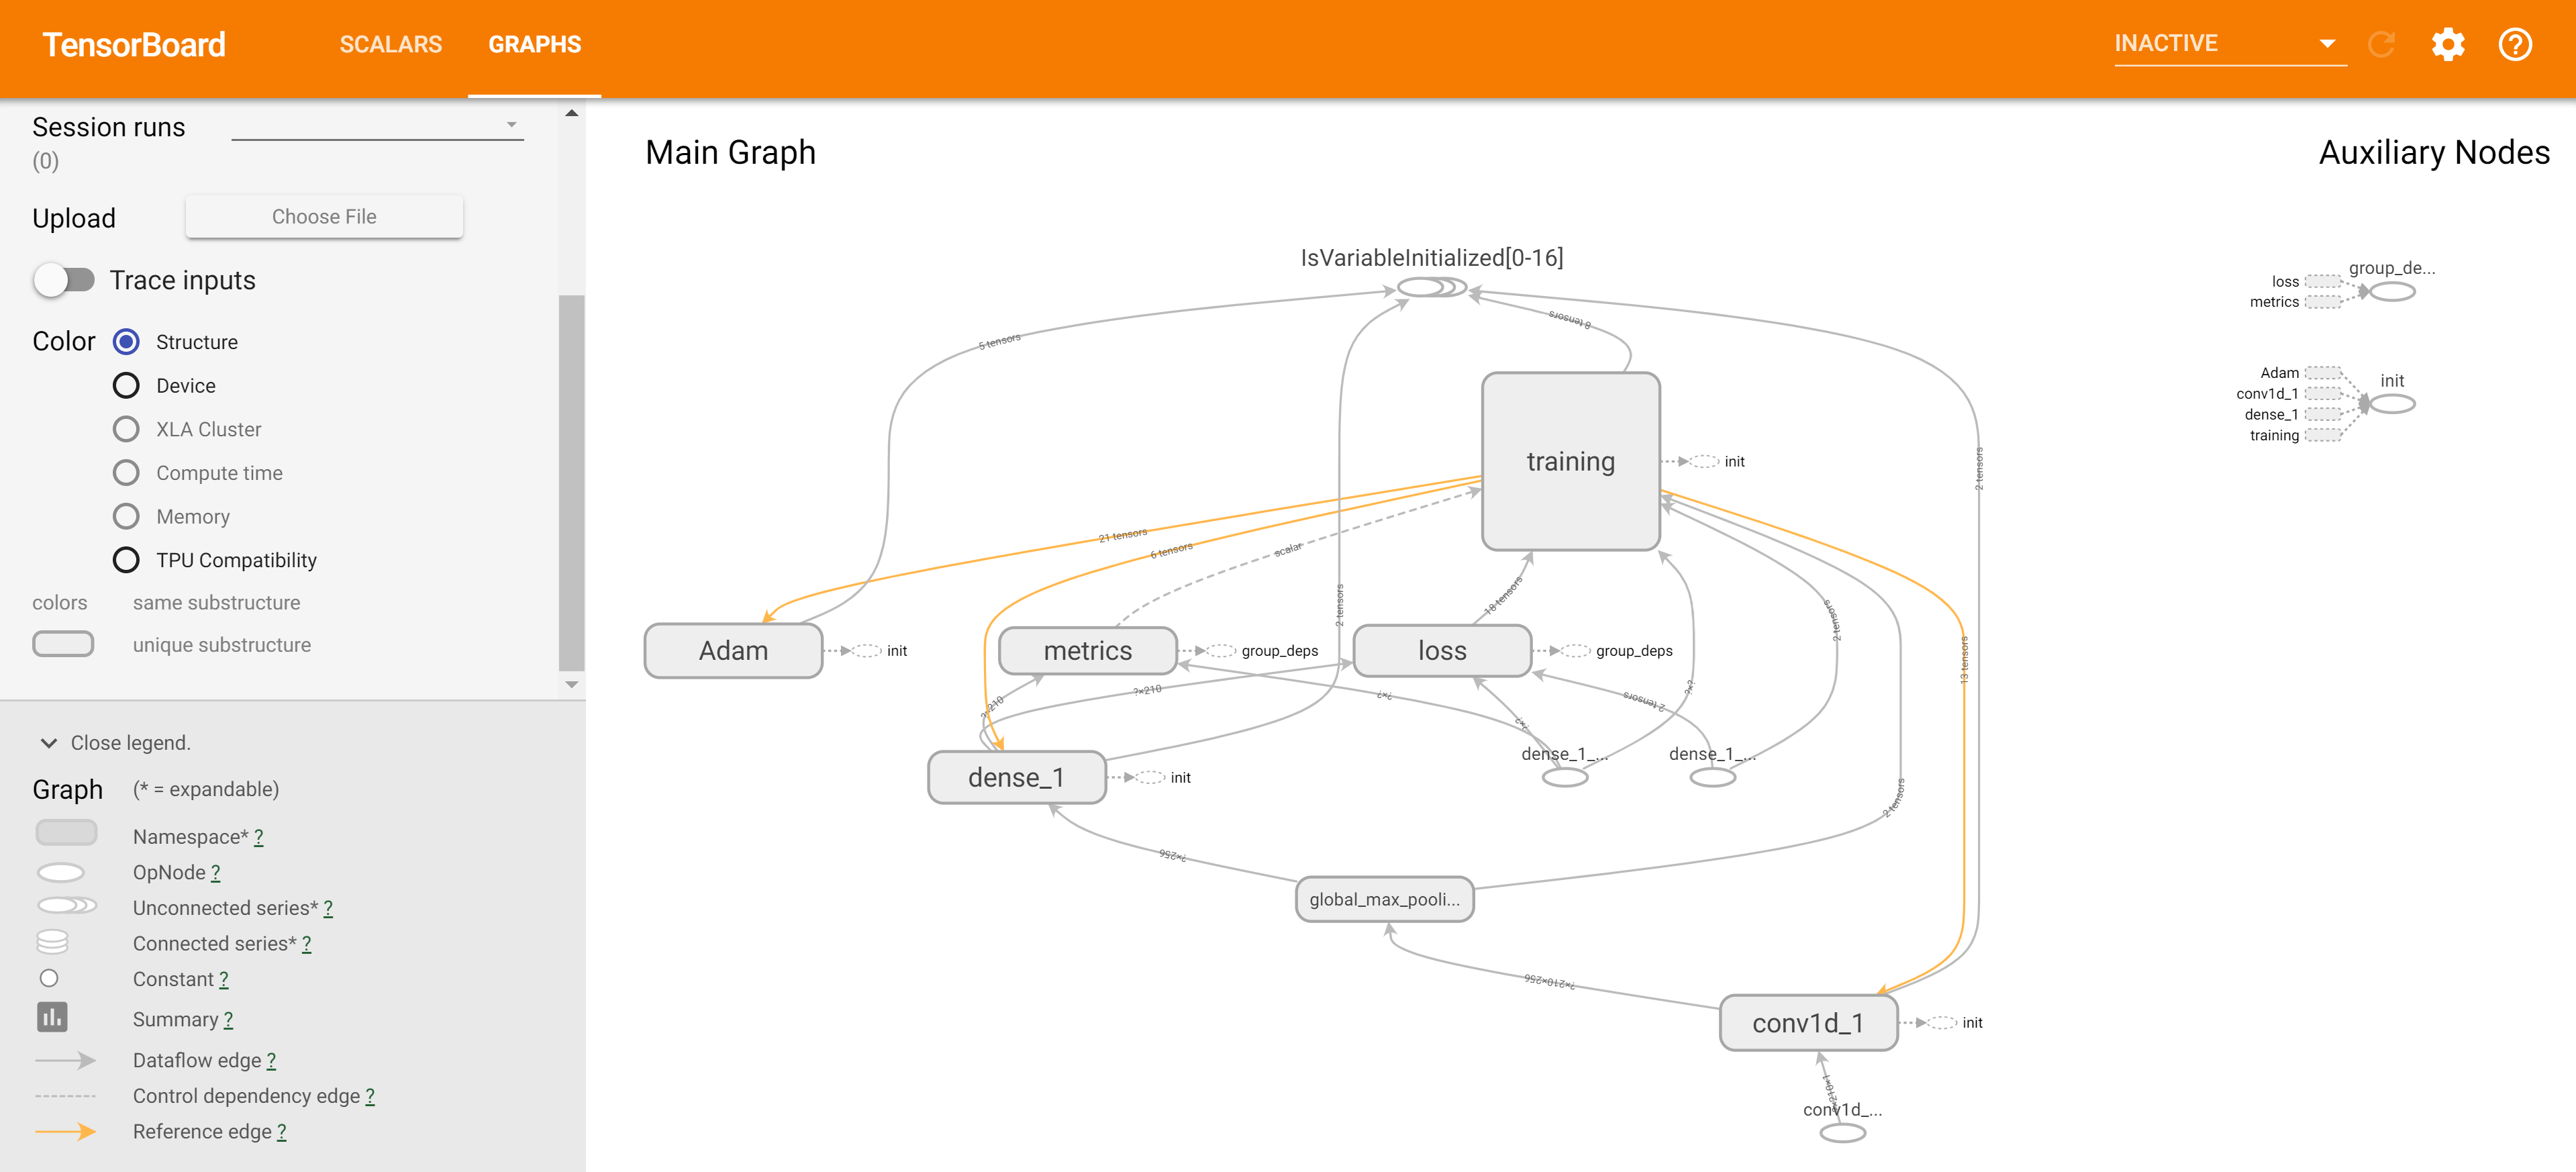

In [16]:
i = i = Image(filename='C:/Users/DELL/Pictures/TensorBoard/Conv1D/3.PNG')
i

## 6. Performance and Validation of the NN

Now the anomaly detection

# 0 is normal (dist: 0.32032729372184576)
# 1 is normal (dist: 0.3529996426211889)
# 2 is normal (dist: 0.3846988186362842)
# 3 is normal (dist: 0.4180971749644787)
# 4 is normal (dist: 0.3650565405196149)
# 5 is normal (dist: 0.343529768523278)
# 6 is normal (dist: 0.341283981874237)
# 7 is normal (dist: 0.3894456530945373)
# 8 is normal (dist: 0.38254398371698817)
# 9 is normal (dist: 0.3838508653093652)
# 10 is normal (dist: 0.3787204341889207)
# 11 is normal (dist: 0.3597045786159159)
# 12 is normal (dist: 0.3671465472517718)
# 13 is normal (dist: 0.3720903019724554)
# 14 is normal (dist: 0.4502549927341108)
# 15 is normal (dist: 0.3546673856706506)
# 16 is normal (dist: 0.3276874014641199)
# 17 is normal (dist: 0.3161838808450201)
# 18 is normal (dist: 0.32741943881508107)
# 19 is normal (dist: 0.5080159915958558)
# 20 is normal (dist: 0.49803245777052135)
# 21 is normal (dist: 0.593622563058442)
# 22 is normal (dist: 0.529662889498522)
# 23 is normal (dist: 0.7256768270162959)
# 

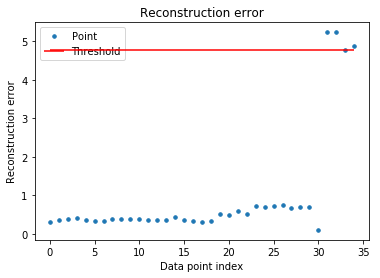

In [17]:
## For each of the observations it predicts wheter or not is an anomaly
estimated_negative_sample_ratio = 0.9
input_timeseries_dataset = np.expand_dims(df_np_data , axis=2)
target_timeseries_dataset = model.predict(x=input_timeseries_dataset)
dist = np.linalg.norm(df_np_data  - target_timeseries_dataset, axis=-1)
scores = dist
scores.sort()
cut_point = int(estimated_negative_sample_ratio * len(scores))
threshold = scores[cut_point]

dist = np.linalg.norm(df_np_data  - target_timeseries_dataset, axis=-1)

Result=zip(dist >= threshold, dist)

reconstruction_error = []
for idx, (is_anomaly, dist) in enumerate(Result):
    print('# ' + str(idx) + ' is ' + ('abnormal' if is_anomaly else 'normal') + ' (dist: ' + str(dist) + ')')
    reconstruction_error.append(dist)

# Visualize the anomalies
visualize_reconstruction_error(reconstruction_error, threshold)

Now the ROC Curve and the confusion matrix

In [18]:
TClass=pd.DataFrame(labels,columns=["Class"])
TClass['Rec_Error'] = pd.Series(reconstruction_error).values
TClass

Class  Rec_Error
0       0   0.320327
1       0   0.353000
2       0   0.384699
3       0   0.418097
4       0   0.365057
5       0   0.343530
6       0   0.341284
7       0   0.389446
8       0   0.382544
9       0   0.383851
10      0   0.378720
11      0   0.359705
12      0   0.367147
13      0   0.372090
14      0   0.450255
15      0   0.354667
16      0   0.327687
17      0   0.316184
18      0   0.327419
19      0   0.508016
20      0   0.498032
21      0   0.593623
22      0   0.529663
23      0   0.725677
24      0   0.695769
25      0   0.729520
26      0   0.755978
27      0   0.666423
28      0   0.712602
29      0   0.710705
30      1   0.107982
31      1   5.223083
32      1   5.228237
33      1   4.761478
34      1   4.876347

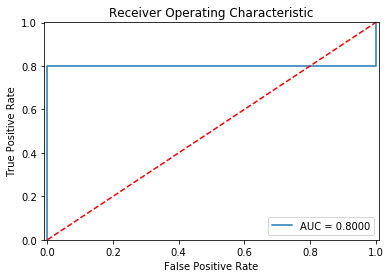

In [19]:
## ROC CURVE
fpr, tpr, thresholds = roc_curve(TClass.Class, TClass.Rec_Error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


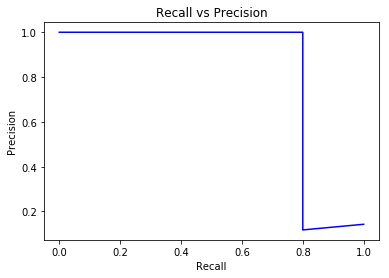

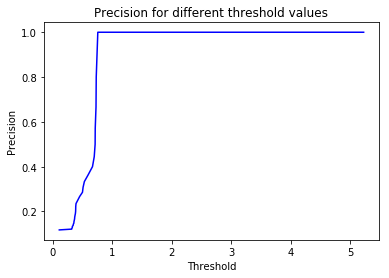

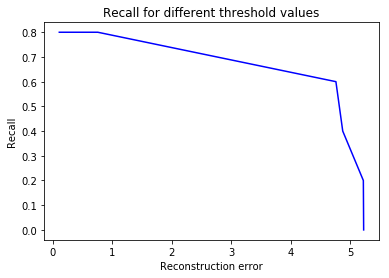

In [20]:
#Quality  metrics and graphs for the model of anomaly detection

precision, recall, th = precision_recall_curve(TClass.Class, TClass.Rec_Error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()


plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

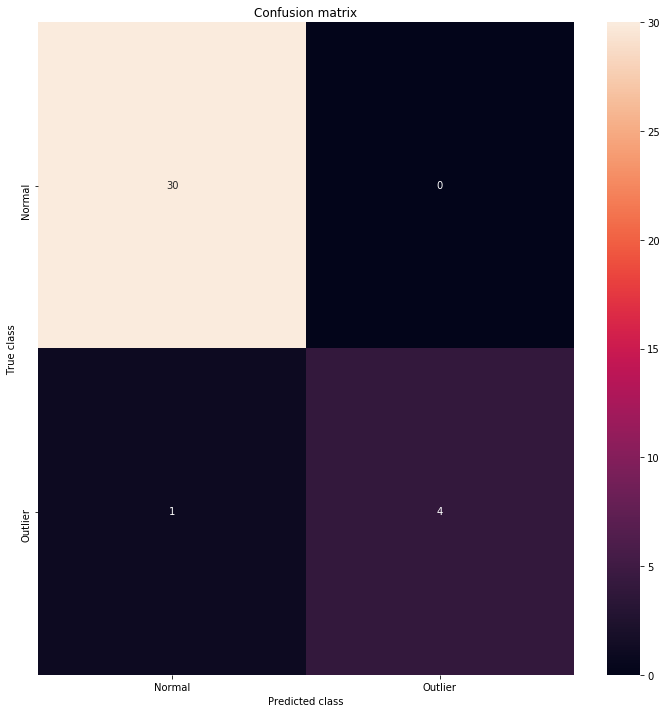

In [21]:
## CONFUSSION MATRIX
LABELS = ["Normal", "Outlier"]

y_pred = [1 if e >= threshold else 0 for e in TClass.Rec_Error.values]
conf_matrix = confusion_matrix(TClass.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## 7. Deployment of the NN to Google Cloud

The model we trained needs to be in keras with this configuration

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', input_shape=(df_np_data.shape[1], 1)))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dense(units=df_np_data.shape[1], activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(x=Xin, y=Yin,batch_size=8, epochs=100,verbose=2 ,validation_split=0.1)

Train on 31 samples, validate on 4 samples
Epoch 1/100
 - 0s - loss: 0.0288 - mean_absolute_error: 0.1101 - val_loss: 0.4725 - val_mean_absolute_error: 0.6402
Epoch 2/100
 - 0s - loss: 0.0241 - mean_absolute_error: 0.0943 - val_loss: 0.4025 - val_mean_absolute_error: 0.5828
Epoch 3/100
 - 0s - loss: 0.0188 - mean_absolute_error: 0.0784 - val_loss: 0.3322 - val_mean_absolute_error: 0.5192
Epoch 4/100
 - 0s - loss: 0.0141 - mean_absolute_error: 0.0637 - val_loss: 0.2646 - val_mean_absolute_error: 0.4513
Epoch 5/100
 - 0s - loss: 0.0105 - mean_absolute_error: 0.0534 - val_loss: 0.2095 - val_mean_absolute_error: 0.3901
Epoch 6/100
 - 0s - loss: 0.0091 - mean_absolute_error: 0.0528 - val_loss: 0.1689 - val_mean_absolute_error: 0.3424
Epoch 7/100
 - 0s - loss: 0.0086 - mean_absolute_error: 0.0568 - val_loss: 0.1468 - val_mean_absolute_error: 0.3156
Epoch 8/100
 - 0s - loss: 0.0085 - mean_absolute_error: 0.0597 - val_loss: 0.1349 - val_mean_absolute_error: 0.3016
Epoch 9/100
 - 0s - loss: 0.0

Epoch 71/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0281 - val_loss: 0.1172 - val_mean_absolute_error: 0.2805
Epoch 72/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.1174 - val_mean_absolute_error: 0.2807
Epoch 73/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.1172 - val_mean_absolute_error: 0.2805
Epoch 74/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0278 - val_loss: 0.1173 - val_mean_absolute_error: 0.2808
Epoch 75/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0276 - val_loss: 0.1176 - val_mean_absolute_error: 0.2811
Epoch 76/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0274 - val_loss: 0.1176 - val_mean_absolute_error: 0.2811
Epoch 77/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0274 - val_loss: 0.1177 - val_mean_absolute_error: 0.2811
Epoch 78/100
 - 0s - loss: 0.0014 - mean_absolute_error: 0.0274 - val_loss: 0.1180 - val_mean_absolute_error: 0.2814
Epoch 79/100
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0271 

One we sucessfully train a validated NN with good performance, we can deploy the model into google cloud in order to be able to request predictions from any  computer. In order to acoplish this we must follow the steps:

1. Google cloud only accepts models created in SckitLear, XGboost and TensorFlow. Given that our neural network was created using the library Keras with a TensorFlow backend our first steps must be convert the Keras model into a TensorFlow SavedModel

In [23]:
model_input_name = model.input_names[0]
estimator_model = keras.estimator.model_to_estimator(keras_model=model, model_dir="./estimator_model/")

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using config: {'_model_dir': './estimator_model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000189B41DB588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './estimator_model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000189B41DB588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


This code will create a folder named Keras inside the apointed directory. We need to take the files out of that folder and into the root apointed directory.

2. Now we need to create a function that tells the model the kind of inputs it recieves. In this case it needs to be a time series of 210 records, because that was the input for the previously  trained NN

In [24]:
def serving_input_receiver_fn():
    Series = {model_input_name:tf.placeholder(dtype=tf.float32,name='Time_Series',shape=[None,210,1]),}
    return tf.estimator.export.ServingInputReceiver(Series, Series)

3. Now we export the model as a .pb (TensorFlow Extension)

In [25]:
export_path = estimator_model.export_savedmodel('./', serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from ./estimator_model/keras_model.ckpt


INFO:tensorflow:Restoring parameters from ./estimator_model/keras_model.ckpt


Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: .\temp-b'1547486173'\saved_model.pb


INFO:tensorflow:SavedModel written to: .\temp-b'1547486173'\saved_model.pb


This will create a folder with: A file called SavedModel.pb, that contains the model, and a folder caller variables,  that contains the weights of the trained network

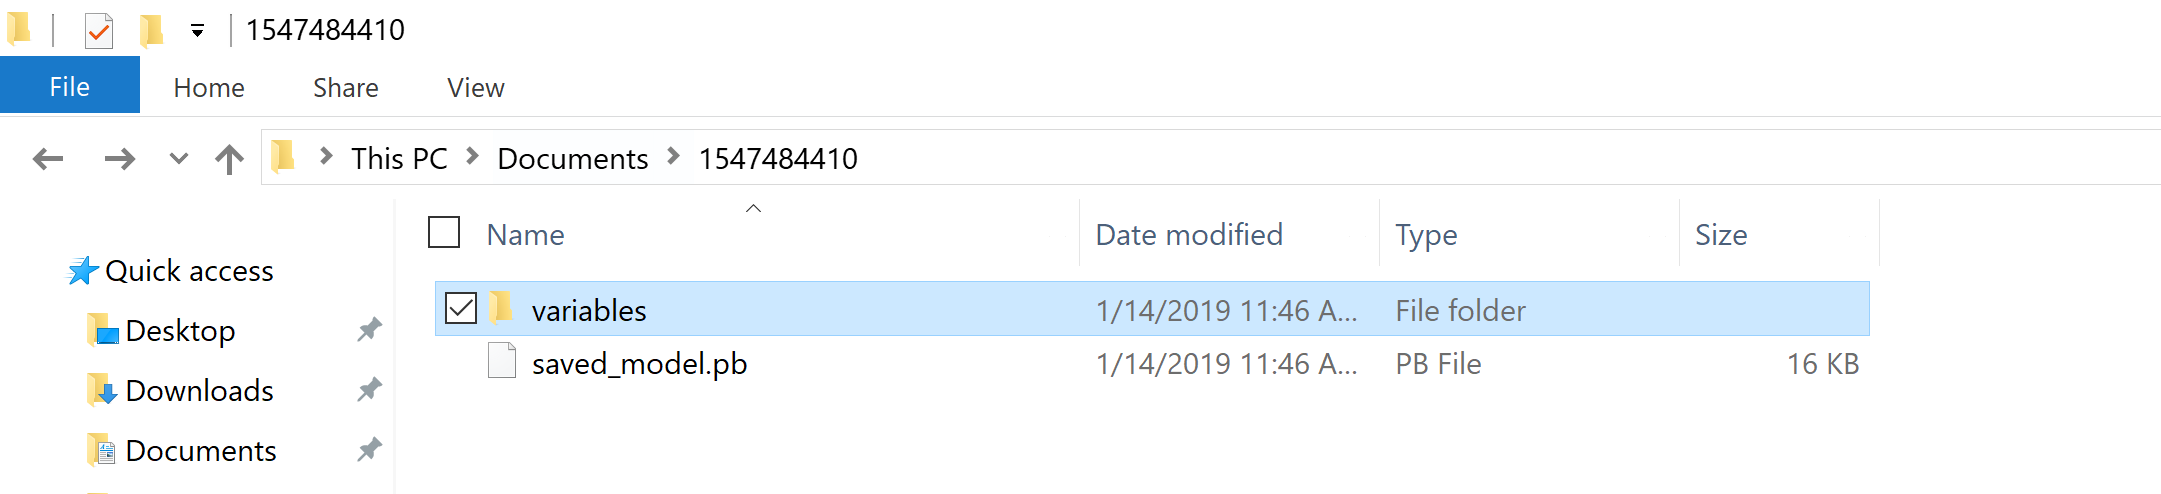

In [26]:
i = Image(filename='C:/Users/DELL/Pictures/Folder.PNG')
i

4. The files created in step 3 need to be uploaded to a bucket in google cloud storage

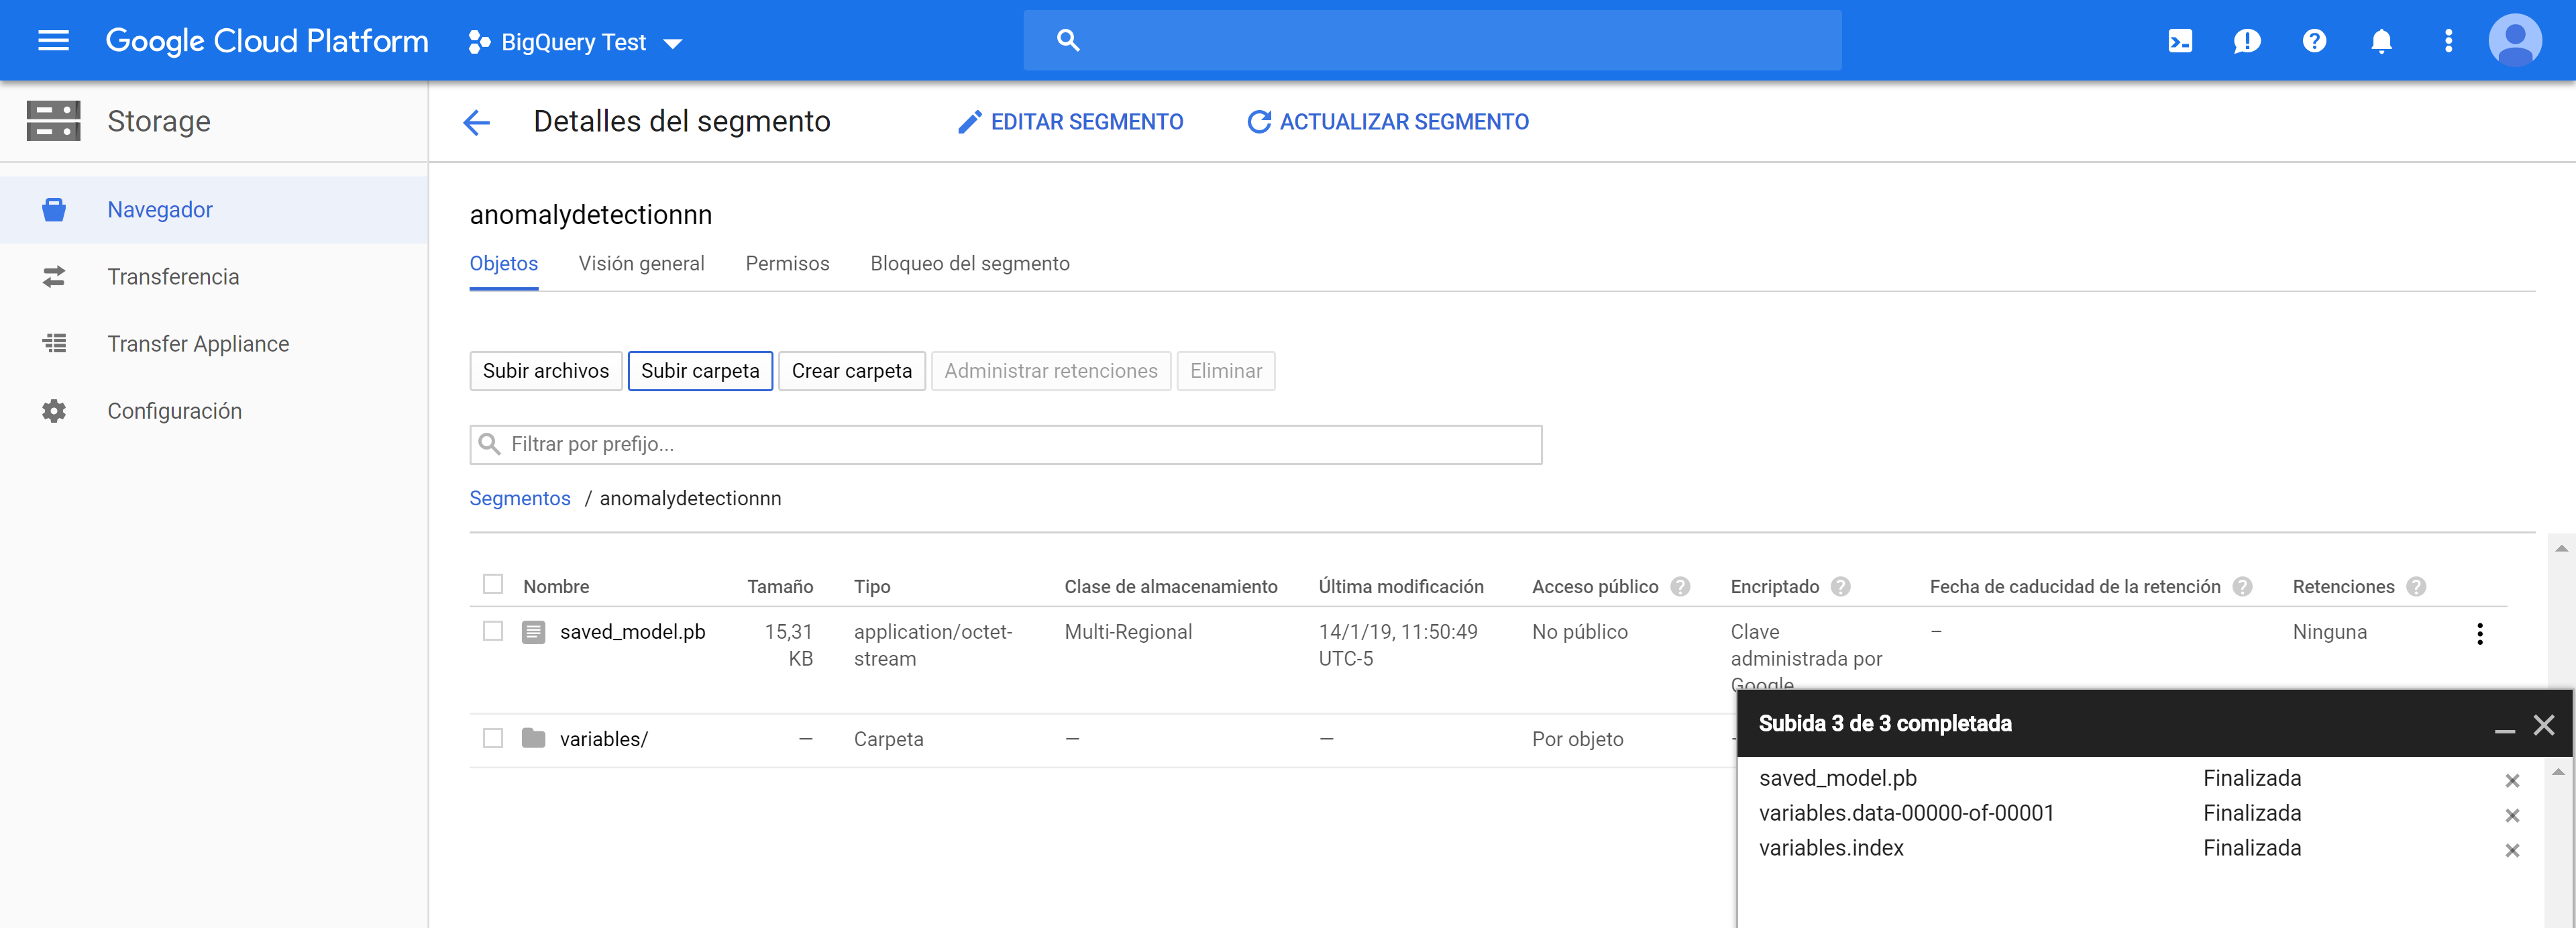

In [27]:
i = Image(filename='C:/Users/DELL/Pictures/Bucket.PNG')
i

5. We now go to de machine learning engine and create a model and a version

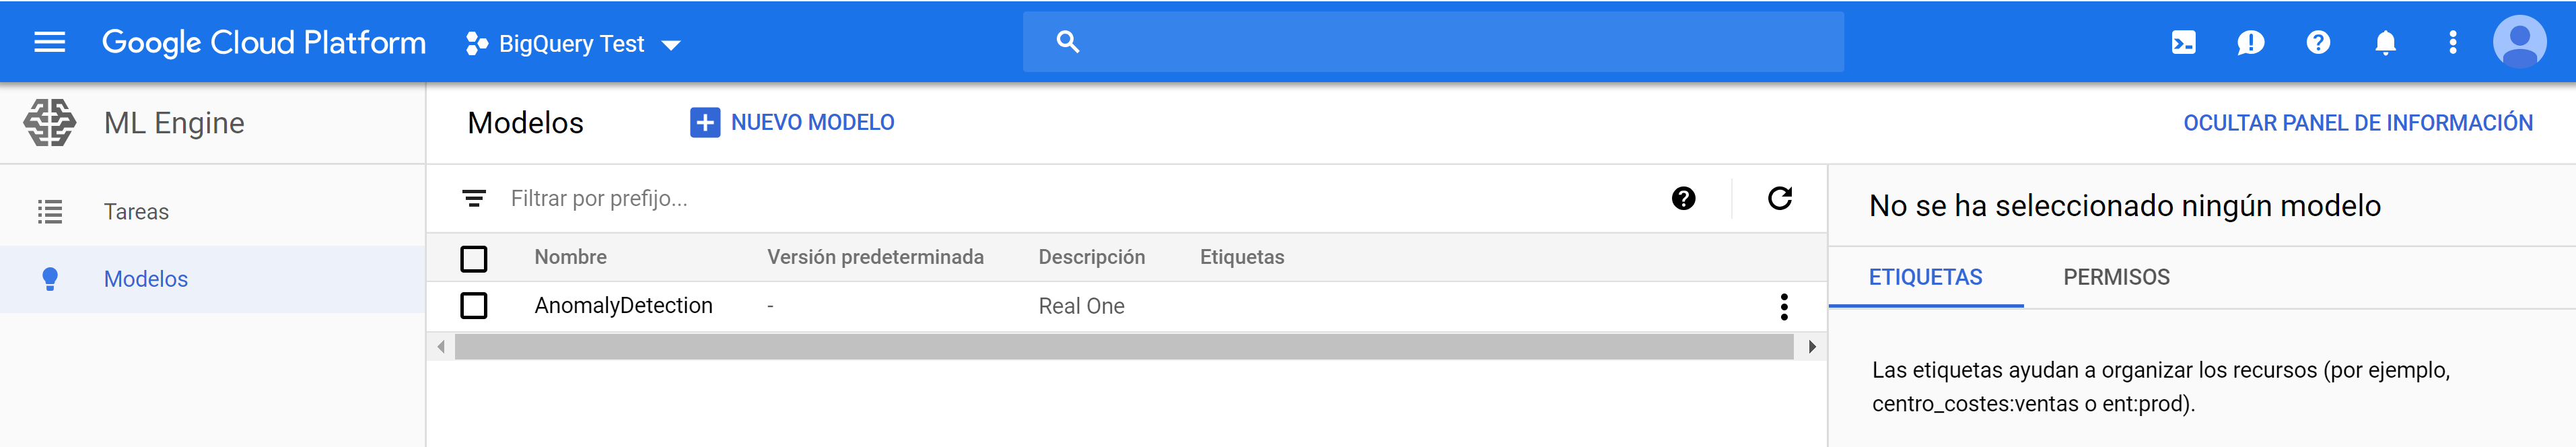

In [28]:
i = Image(filename='C:/Users/DELL/Pictures/Model.PNG')
i

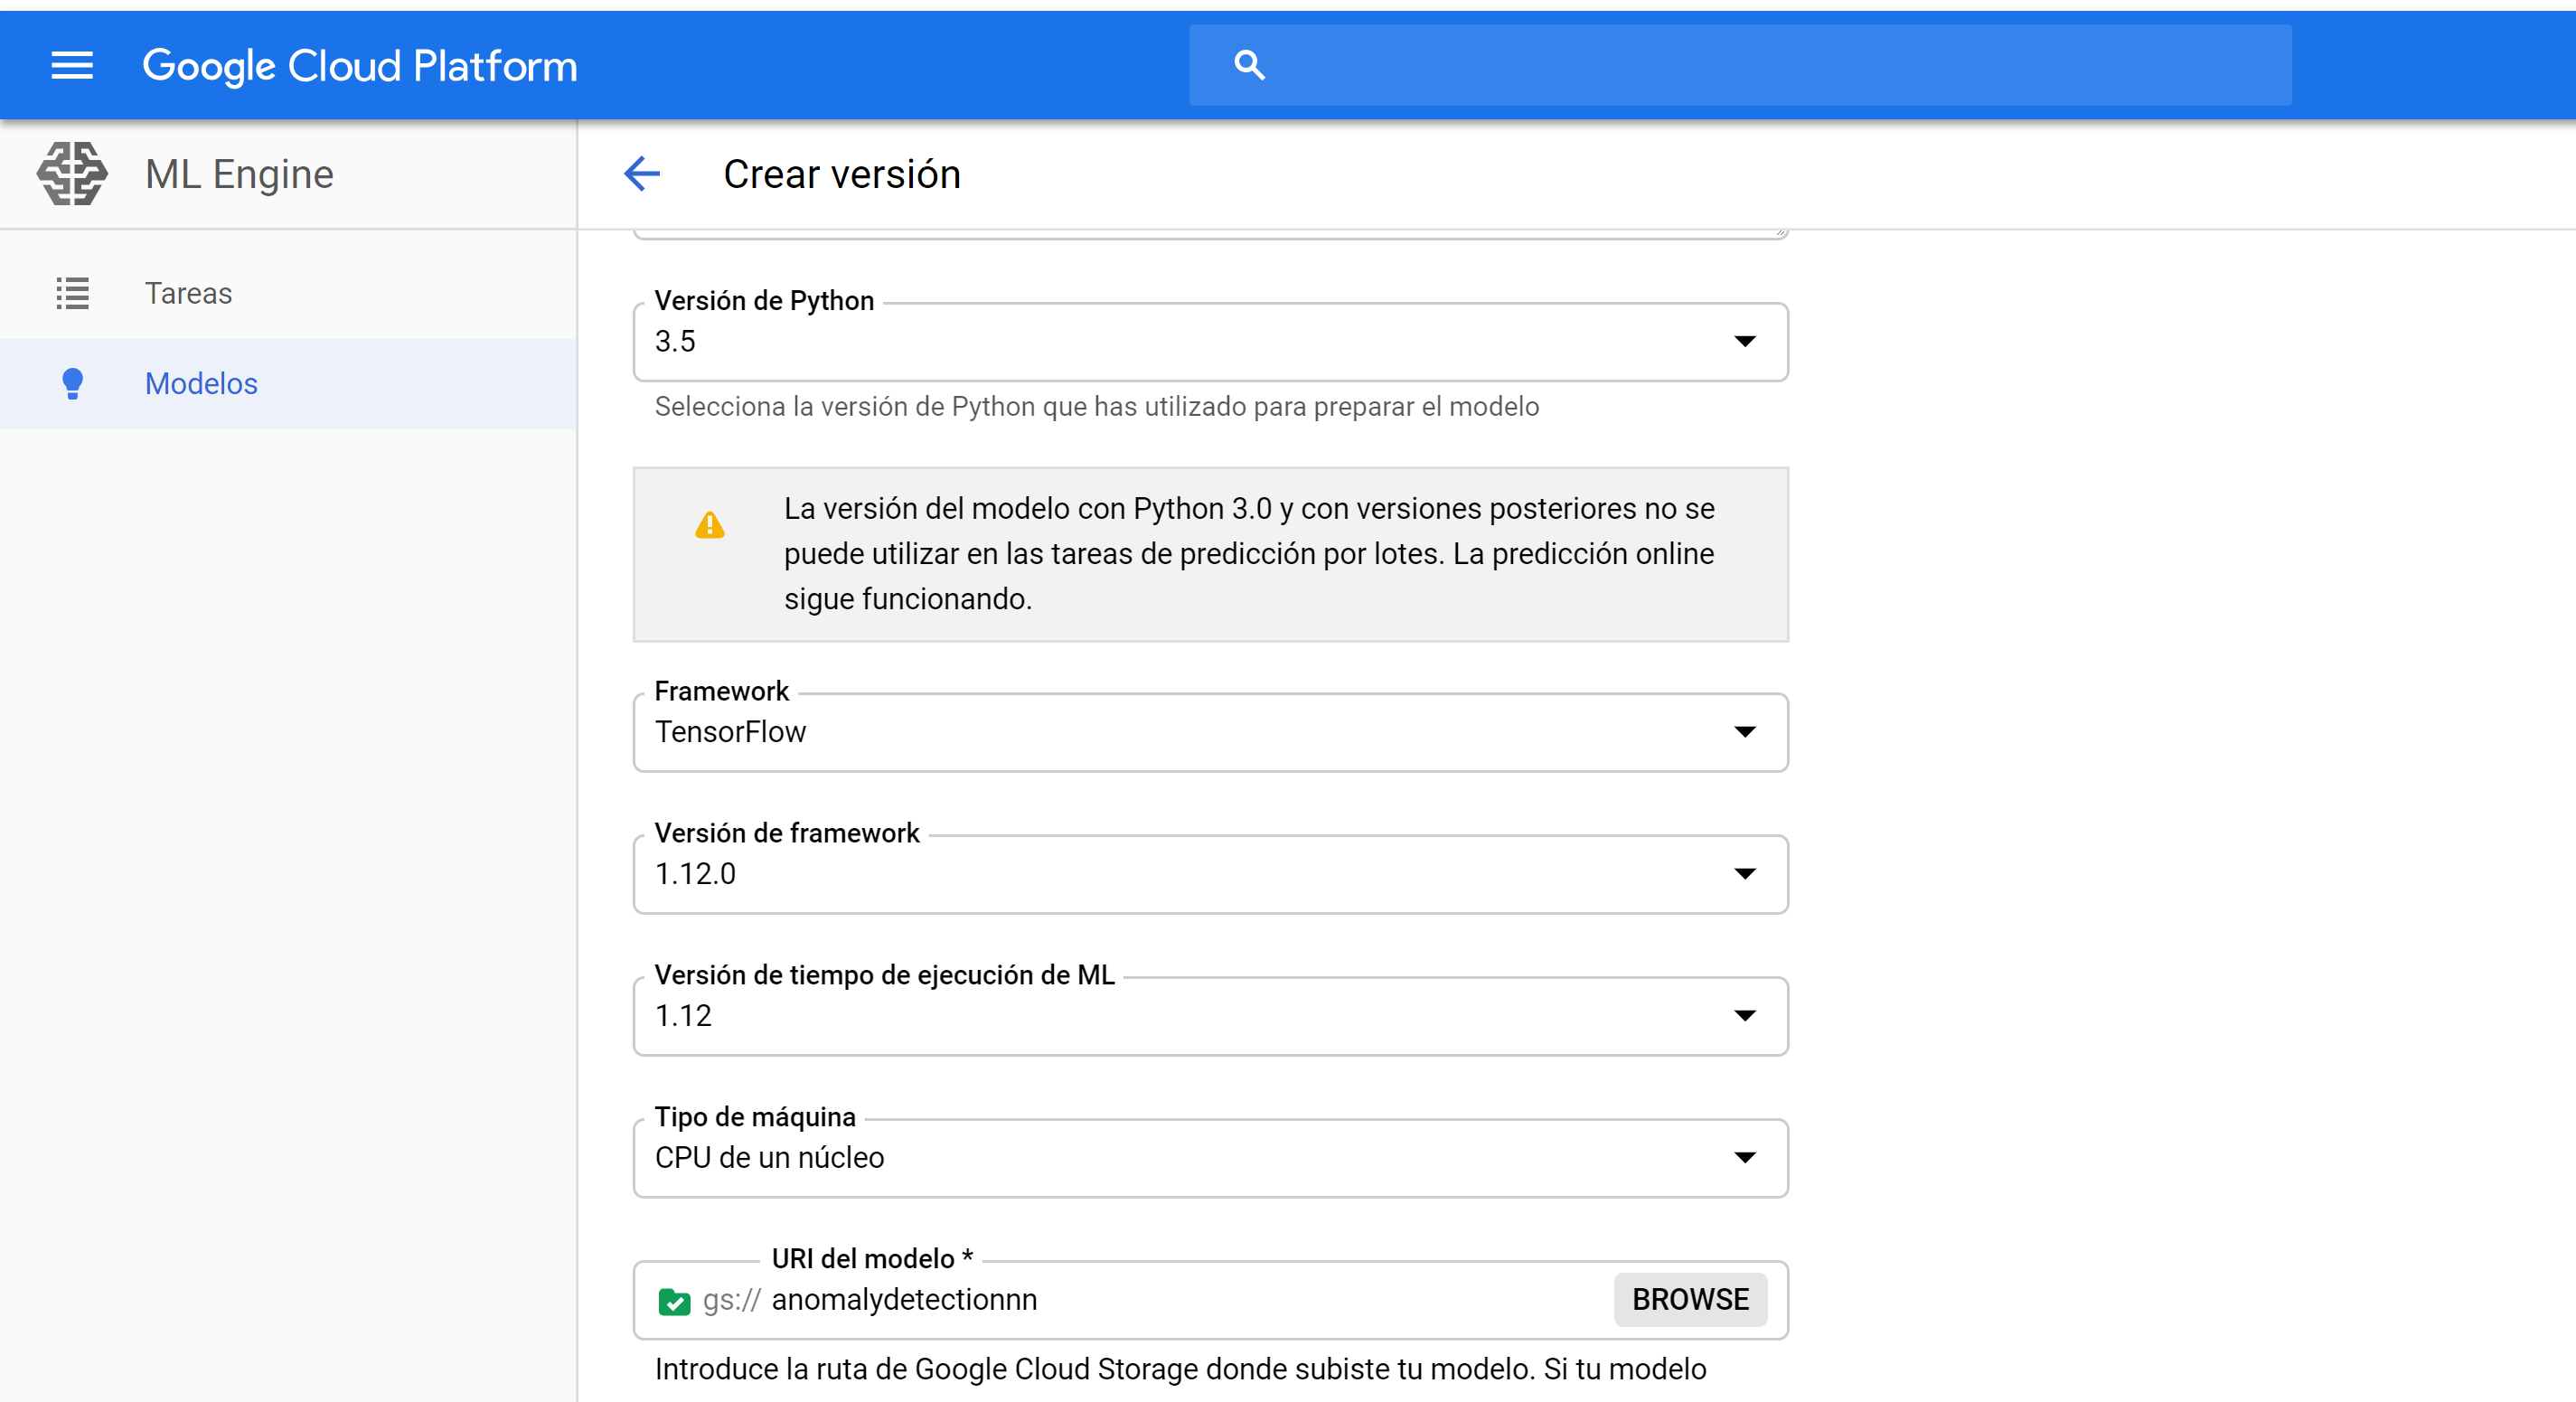

In [29]:
i = Image(filename='C:/Users/DELL/Pictures/Version.PNG')
i

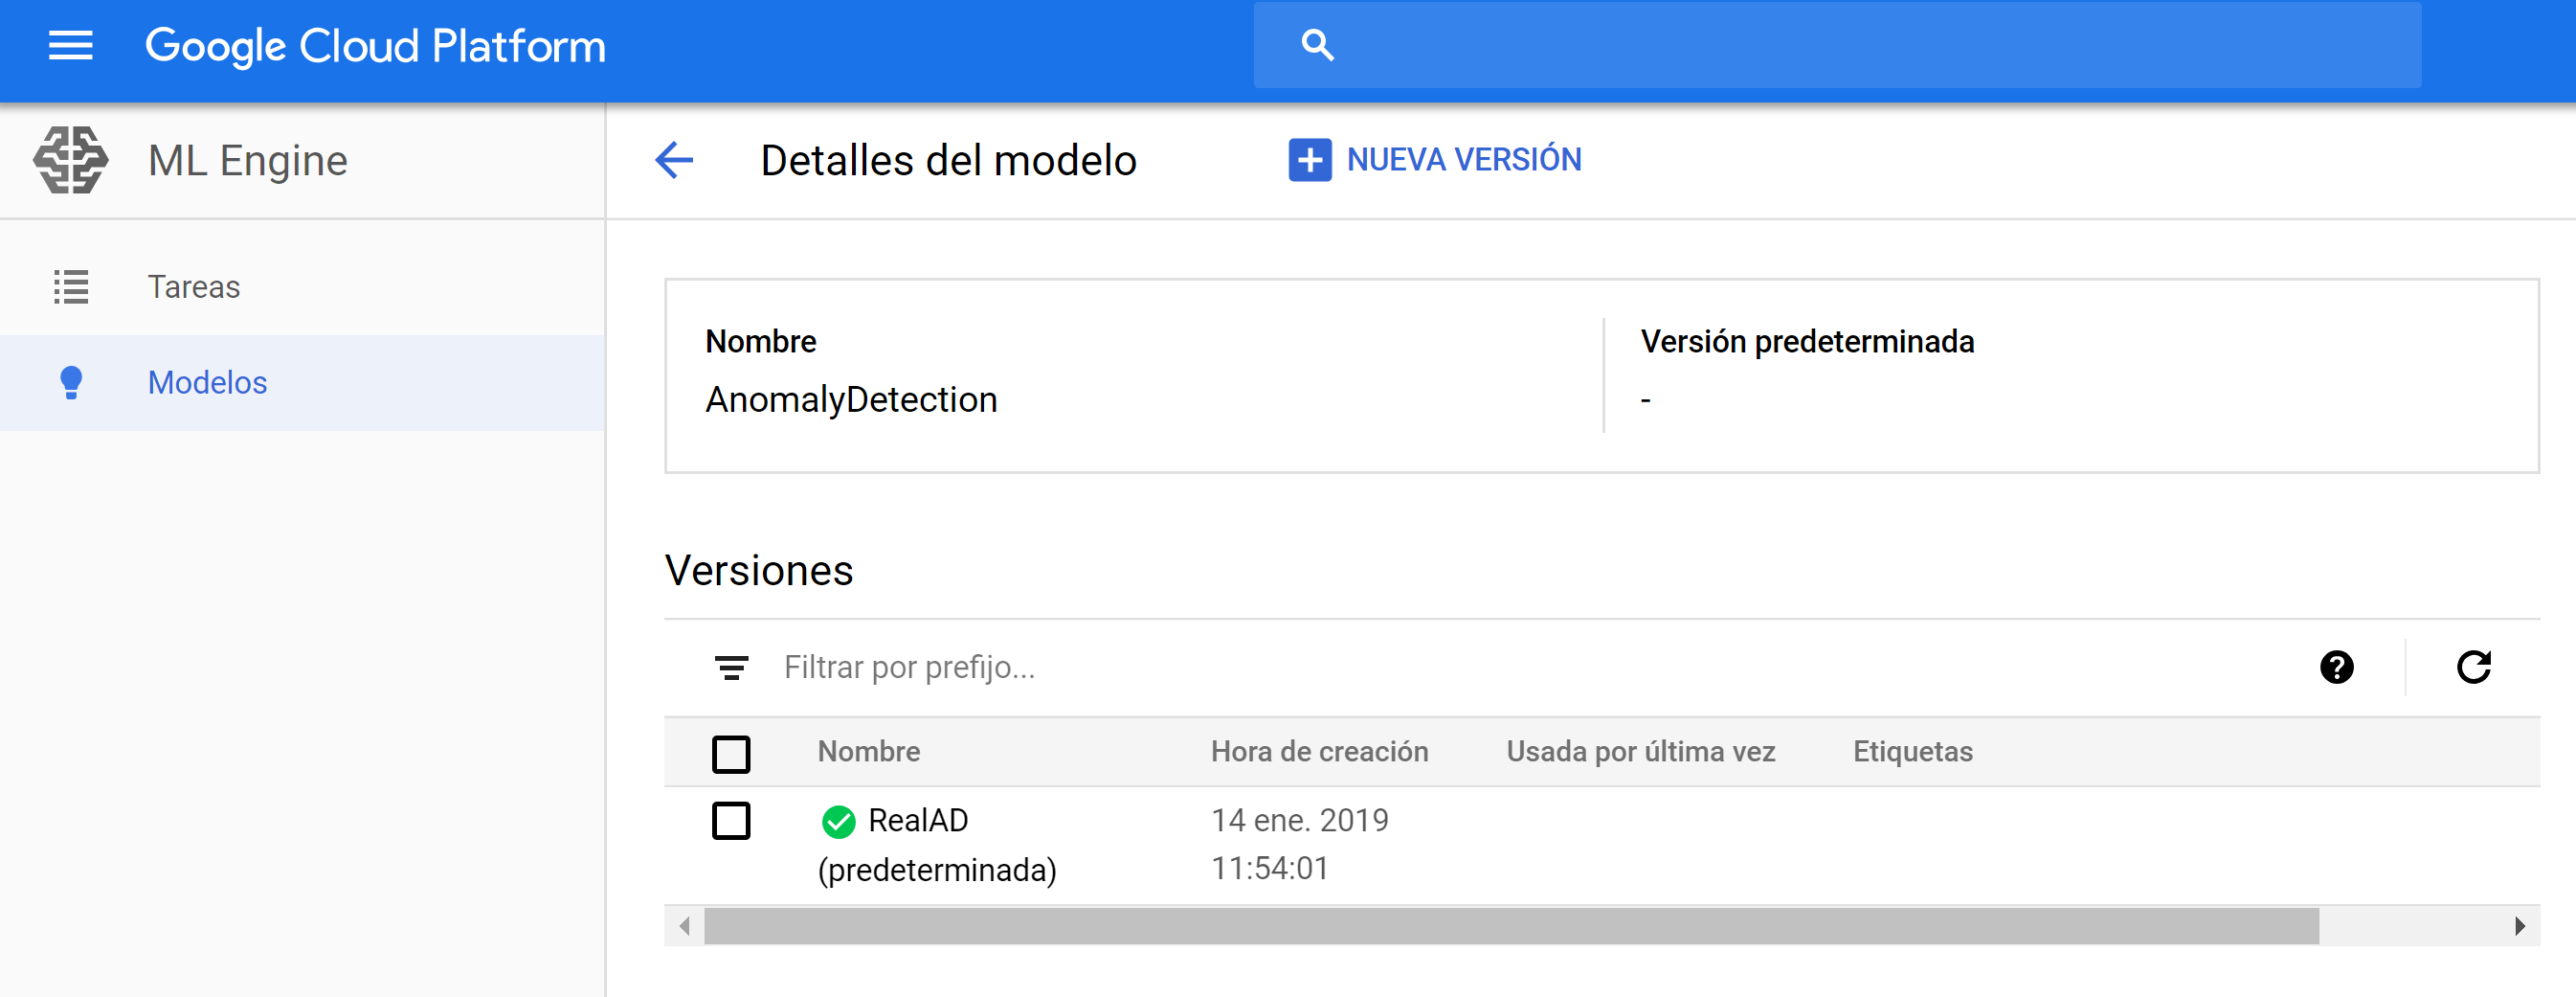

In [30]:
i = Image(filename='C:/Users/DELL/Pictures/VersionC.PNG')
i

6. Now that we have created our model in GCP we can test the predictions. For this, first we need to create a JSON file containing the time series. As an exaple we are gonna take the 24 th series.

In [31]:
Dat=df_np_data[24:25]
Dat=Dat.T
Dat=Dat.tolist()
Predictions={model_input_name:Dat}
json_filename = 'Serie24_Def_1.json'
with open(json_filename, 'w') as outfile:
    json.dump(Predictions, outfile)

7. Finally we get to Google Cloud Shell and excecute the following comands

We define the model name, the version and the input file (This file needs to be uploades to shell first)

MODEL_NAME=AnomalyDetection


INPUT_DATA_FILE="Serie24_Def_1.json"


VERSION_NAME=RealAD

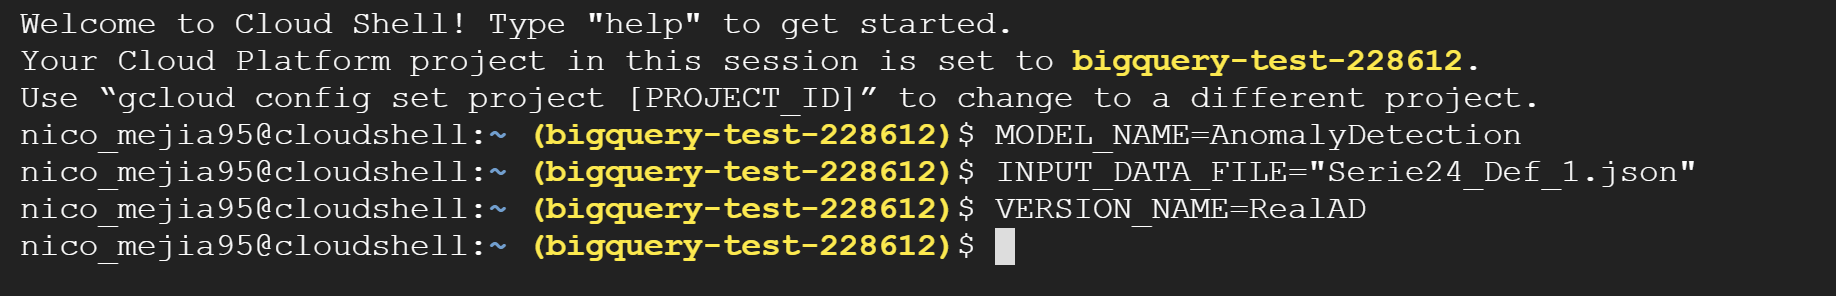

In [32]:
i = Image(filename='C:/Users/DELL/Pictures/Shell.PNG')
i

With  the parameters defined we request some predictions with the code  


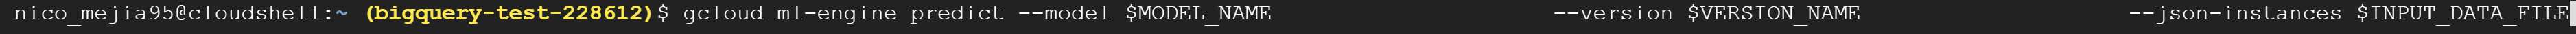

In [34]:
i = Image(filename='C:/Users/DELL/Pictures/Pred.PNG')
i

After runnig the code the requested predictions appear on screen

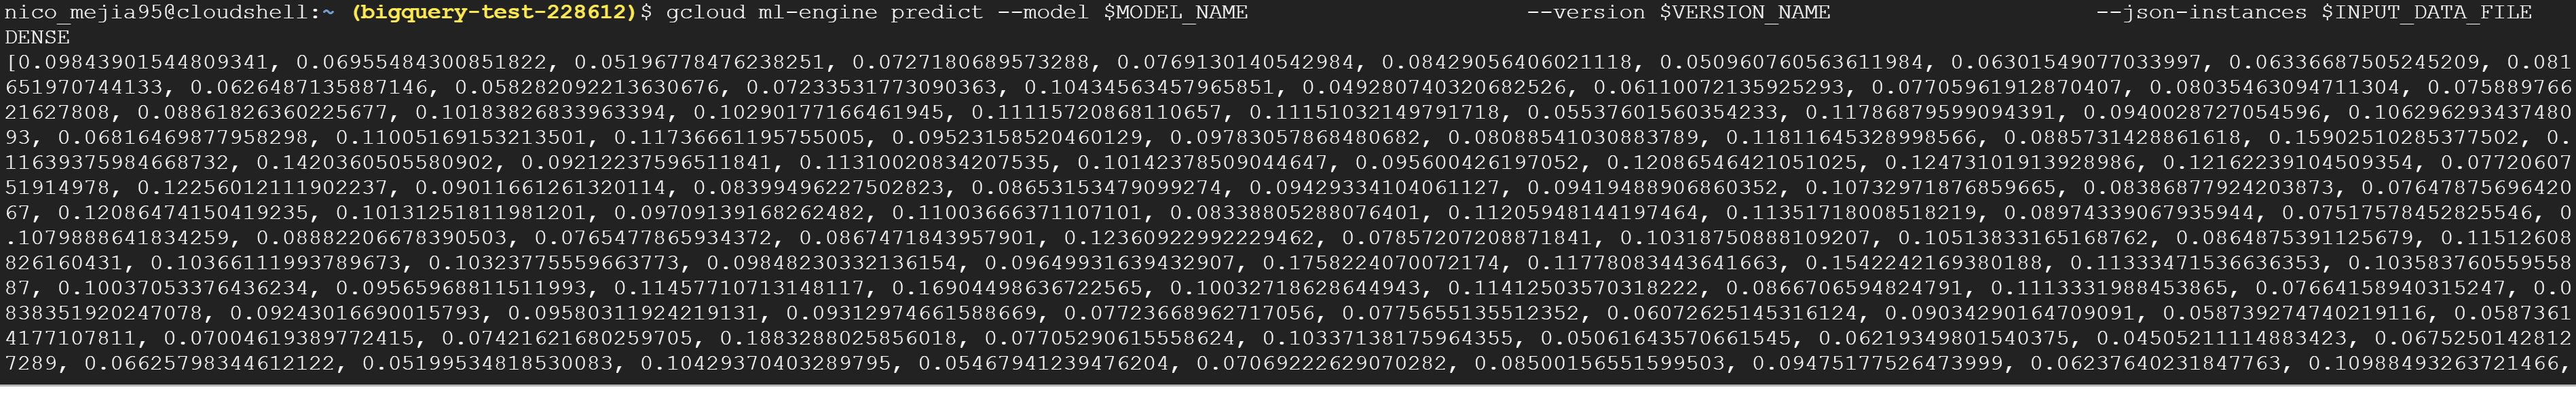

In [35]:
i = Image(filename='C:/Users/DELL/Pictures/Predd.PNG')
i